<h1 style="font-family: 'Arial Black'; color: #1E90FF; text-align: center; font-size: 3em; 
    background: -webkit-linear-gradient(#1E90FF, #00FA9A); -webkit-background-clip: text; -webkit-text-fill-color: transparent;">
    📚 Importation des bibliothèques
</h1>

In [2]:
# Bibliothèques pour la manipulation des données
import pandas as pd
import numpy as np

# ...pour le prétraitement des données
from sklearn.preprocessing import OneHotEncoder

# ...pour la modélisation
from sklearn.model_selection import StratifiedKFold, train_test_split
from catboost import CatBoostClassifier


# ...pour les métriques d'évaluation
from sklearn.metrics import roc_auc_score

# Bibliothèque pour l'optimisation des hyperparamètres
import optuna

# ...pour la visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliothèque pour la gestion des fichiers et du système
import os

# Suppression des messages d'avertissement
import warnings
warnings.filterwarnings('ignore')  # Pour éviter les messages d'avertissement

<h1 style="font-family: 'Arial Black'; color: #1E90FF; text-align: center; font-size: 3em; 
    background: -webkit-linear-gradient(#1E90FF, #00FA9A); -webkit-background-clip: text; -webkit-text-fill-color: transparent;">
    📂 Chargement des données
</h1>

In [4]:
train = pd.read_csv(r'C:\Users\kadas\Desktop\challenge_Data_mining\data\train.csv')
test = pd.read_csv(r'C:\Users\kadas\Desktop\challenge_Data_mining\data\test.csv')

print("Train Data:")
print(train.head())

Train Data:
   id  CustomerId    Surname  CreditScore Geography  Gender   Age  Tenure  \
0   0  15713774.0      Hsieh        683.0   Germany    Male  49.0     7.0   
1   1  15682533.0      Hs?eh        608.0    France  Female  30.0    10.0   
2   2  15791550.0       Tsou        539.0    France  Female  32.0     8.0   
3   3  15762762.0  Chiawuotu        530.0     Spain  Female  39.0     8.0   
4   4  15756475.0     Nnamdi        613.0    France  Female  45.0    10.0   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0  123837.86            2.0        1.0             1.0        138700.75   
1       0.00            2.0        1.0             1.0        146723.72   
2       0.00            1.0        1.0             1.0         94873.60   
3       0.00            2.0        0.0             0.0        177896.93   
4       0.00            2.0        1.0             1.0        116748.14   

   Exited  
0     1.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  


In [5]:
# Sauvegarde de l'identifiant
id = train['id'].copy()

# Suppression des colonnes inutiles
train = train.drop(columns=['id', 'CustomerId', 'Surname'])

In [6]:
# Statistiques descriptives
train.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,658.701800,37.660800,5.038800,42888.826095,1.589467,0.779800,0.497867,117892.175400,0.199333
std,80.238346,8.106408,2.810354,59695.877791,0.532430,0.414395,0.500012,45574.462515,0.399512
min,431.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,602.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,82870.750000,0.000000
50%,661.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,123583.850000,0.000000
75%,709.000000,42.000000,7.000000,109844.810000,2.000000,1.000000,1.000000,157567.370000,0.000000
max,4818.000000,72.000000,10.000000,207034.960000,6.000000,1.000000,1.000000,199761.290000,1.000000


<h1 style="font-family: 'Arial Black'; color: #1E90FF; text-align: center; font-size: 3em; 
    background: -webkit-linear-gradient(#1E90FF, #00FA9A); -webkit-background-clip: text; -webkit-text-fill-color: transparent;">
    🧮 Analyse et prétraitement
</h1>
<hr style="border: none; border-top: 2px solid #1E90FF; width: 50%; margin: auto;">
<h2 style="font-family: 'Arial'; color: #1E90FF; text-align: center; font-size: 1.5em;">
    Focus : CreditScore
</h2>

In [7]:
outliers_creditscore = train[train['CreditScore'] > 850]
print(outliers_creditscore)

       CreditScore Geography  Gender   Age  Tenure  Balance  NumOfProducts  \
11889       4818.0    France  Female  41.0     1.0      0.0            2.0   

       HasCrCard  IsActiveMember  EstimatedSalary  Exited  
11889        1.0             1.0         73418.29     0.0  


On observe la présence d'un outlier avec un max de 4818, ce qui est bien au-delà de ce qui est attendu pour un score de crédit (généralement compris entre 300 et 850). Nous décidons donc de lui imputer la médiane car cela ne présente pas de biais pour une seule observation parmi 15000.

In [8]:
# Calcul de la médiane des CreditScore valides
median_score = train[train['CreditScore'] <= 850]['CreditScore'].median()

# Imputation de la valeur aberrante par la médiane
train.loc[train['CreditScore'] > 850, 'CreditScore'] = median_score

print("Données après imputation :")
print(train['CreditScore'].describe())

Données après imputation :
count    15000.000000
mean       658.424667
std         72.696090
min        431.000000
25%        602.000000
50%        661.000000
75%        709.000000
max        850.000000
Name: CreditScore, dtype: float64


In [9]:
print(train.dtypes)

CreditScore        float64
Geography           object
Gender              object
Age                float64
Tenure             float64
Balance            float64
NumOfProducts      float64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited             float64
dtype: object


In [10]:
# Vérification des valeurs manquantes
print("\nValeurs manquantes dans le train :\n", train.isnull().sum())
print("\nValeurs manquantes dans le test :\n", test.isnull().sum())


Valeurs manquantes dans le train :
 CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Valeurs manquantes dans le test :
 id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64


<h1 style="font-family: 'Arial Black'; color: #1E90FF; text-align: center; font-size: 3em; 
    background: -webkit-linear-gradient(#1E90FF, #00FA9A); -webkit-background-clip: text; -webkit-text-fill-color: transparent;">
    🔍 Analyse graphique des variables catégorielles et numériques


<h2 style="font-family: 'Arial Black'; color: #1E90FF; text-align: left; font-size: 1,7em; 
    border-left: 6px solid #00FA9A); padding-left: 10px;">
    📊 Distribution de la variable cible <code>Exited</code>


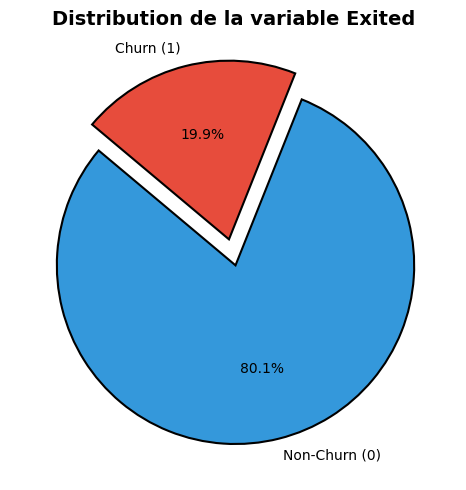

In [11]:
# Proportion des churn
proportion_churn = train['Exited'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(
    proportion_churn,
    labels=['Non-Churn (0)', 'Churn (1)'],
    autopct='%1.1f%%',
    startangle=140,
    explode=[0.05, 0.1], 
    colors=['#3498db', '#e74c3c'], 
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}
)
plt.title("Distribution de la variable Exited", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

<h3 style="color: #FFFFFF; text-align: left; font-size: 1.2em;">
    📊 Interprétation : 
    <span style="color: #FFFFFF;">
        Le graphique ci-dessus illustre la proportion de clients ayant quitté la banque (<code style="color: rgb(6, 5, 63);">1</code>) comparée à ceux qui sont restés fidèles (<code style="color: rgb(3, 12, 85);">0</code>). 
        On remarque une majorité écrasante de <span style="color: #00FA9A; font-weight: bold;">clients restants</span>, représentant environ <span style="color: #00FA9A; font-weight: bold;">80%</span>, contre seulement <span style="color: #FF6347; font-weight: bold;">20%</span> pour les clients ayant quitté.
    </span>
</h3>

<h2 style="font-family: 'Arial Black'; color: #1E90FF; text-align: left; font-size: 1,7em; 
    border-left: 6px solid #00FA9A); padding-left: 10px;">
    📊 Analyse des relations entre les variables catégorielles et la cible <code>Exited</code>


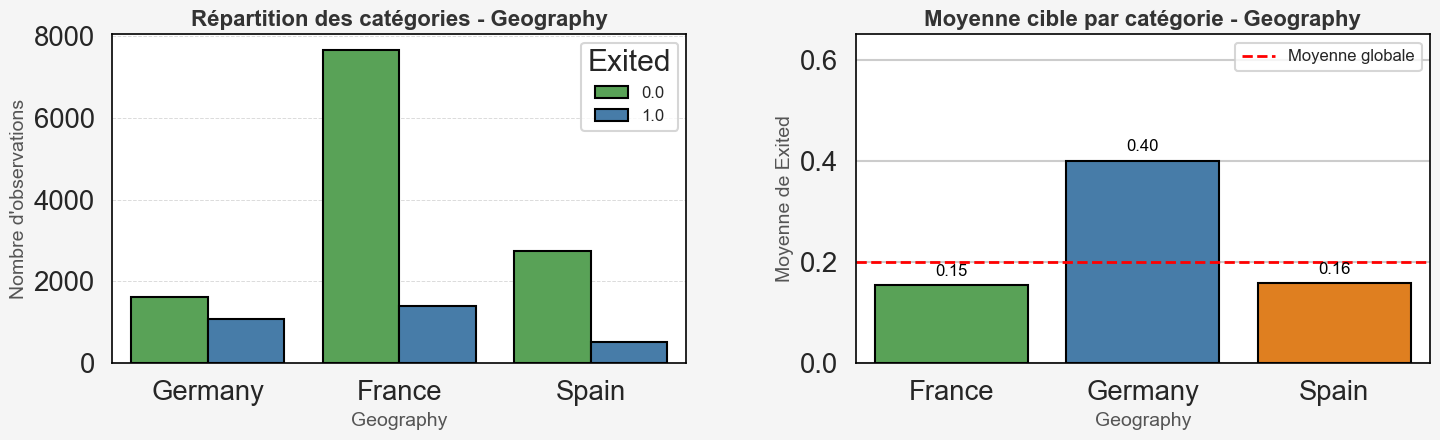

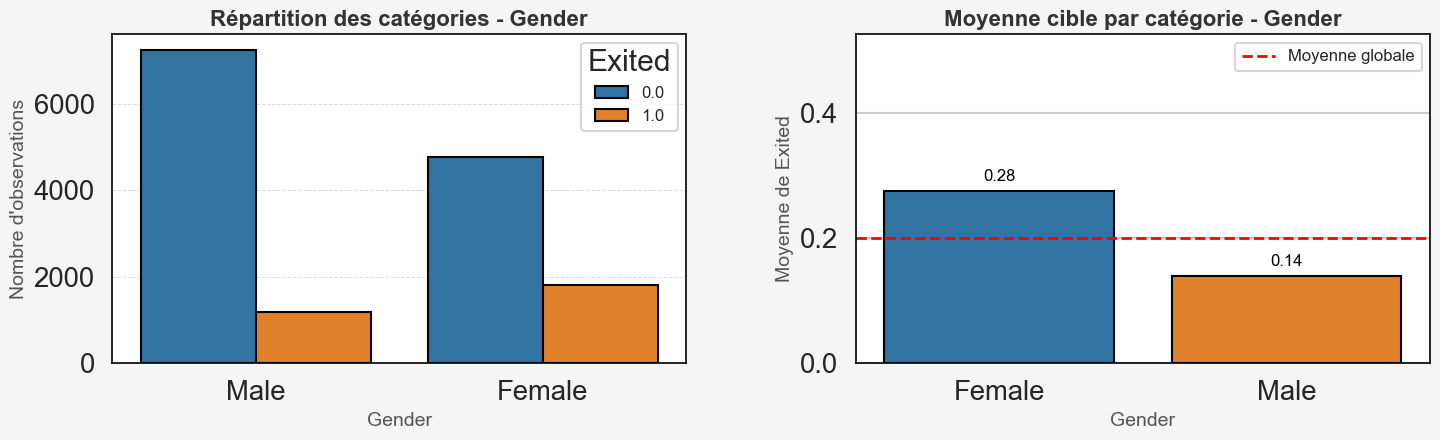

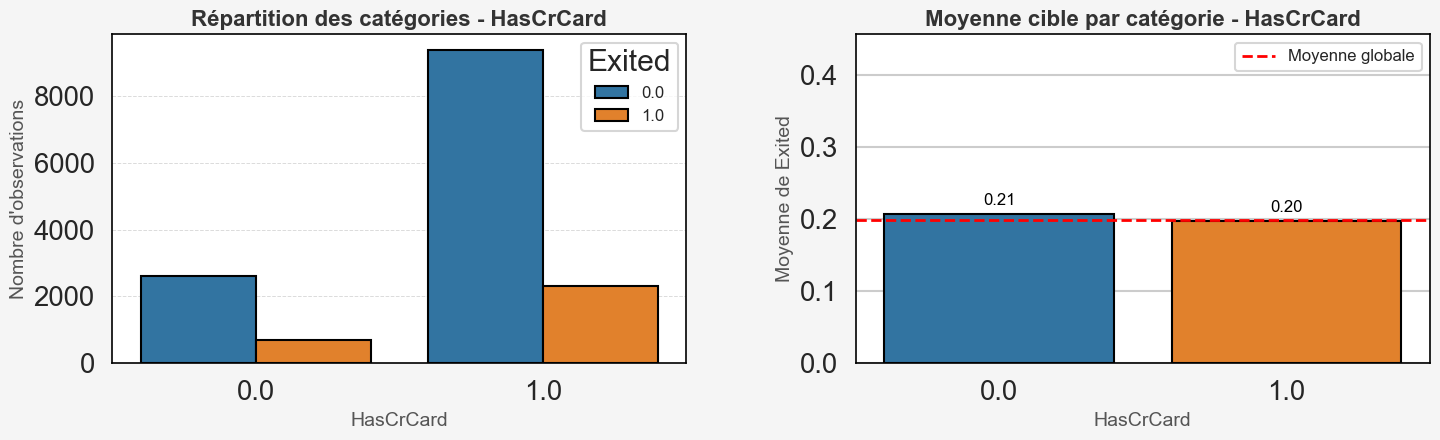

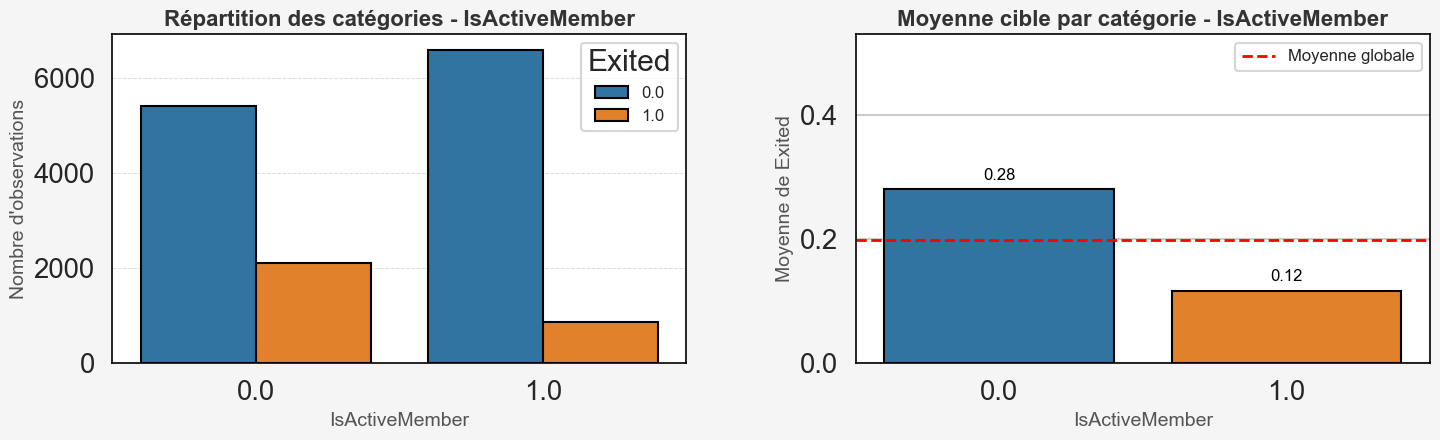

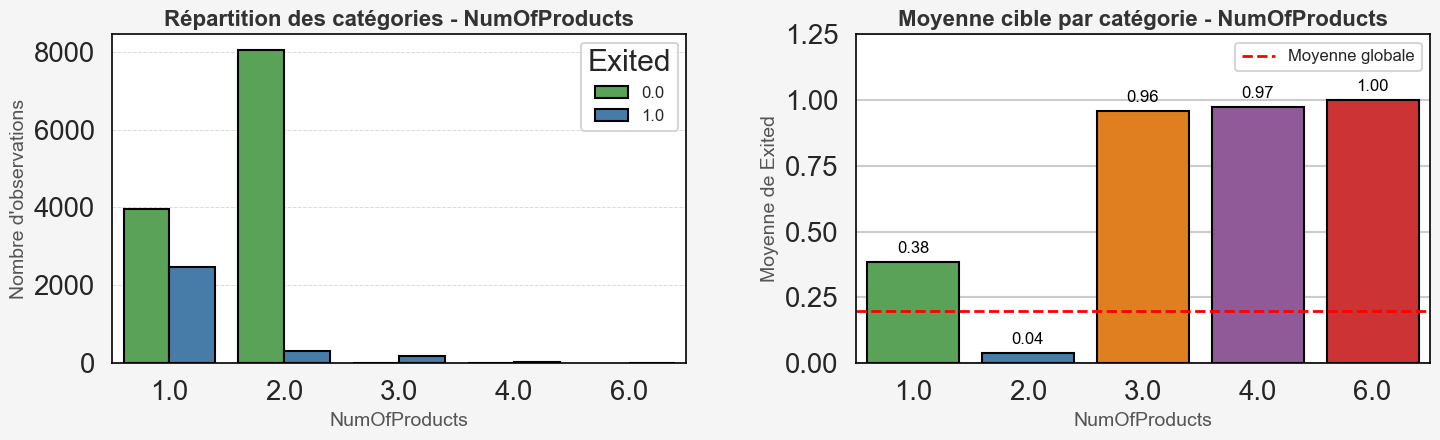

In [13]:
sns.set(style="whitegrid", context="talk", font_scale=1.2)
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.2

# Liste des variables catégoriques
var_cat = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts']

# Moyenne globale de la cible
moyenne_churn = train['Exited'].mean()

palette_multiple = ['#4daf4a', '#377eb8', '#ff7f00', '#984ea3', '#e41a1c']

# Boucle pour créer les graphiques
for col in var_cat:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [2, 2]}, facecolor="#f5f5f5")
    
    # Graphique 1 : Countplot
    ax1 = axes[0]
    palette = palette_multiple if train[col].nunique() > 2 else ['#1f77b4', '#ff7f0e']
    sns.countplot(data=train, x=col, hue='Exited', palette=palette, ax=ax1, linewidth=1.5, edgecolor="black")
    ax1.set_title(f"Répartition des catégories - {col}", fontsize=16, fontweight="bold", color="#333333")
    ax1.set_xlabel(f"{col}", fontsize=14, color="#555555")
    ax1.set_ylabel("Nombre d'observations", fontsize=14, color="#555555")
    ax1.legend(title="Exited", fontsize=12, loc="upper right", fancybox=True)
    ax1.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
    
    # Graphique 2 : Moyenne cible
    ax2 = axes[1]
    moyenne_categorielle = train.groupby(col)['Exited'].mean()
    sns.barplot(x=moyenne_categorielle.index, y=moyenne_categorielle.values, palette=palette[:len(moyenne_categorielle)], ax=ax2, edgecolor="black")
    ax2.axhline(moyenne_churn, color='red', linestyle='--', linewidth=2, label='Moyenne globale')
    ax2.set_title(f"Moyenne cible par catégorie - {col}", fontsize=16, fontweight="bold", color="#333333")
    ax2.set_xlabel(f"{col}", fontsize=14, color="#555555")
    ax2.set_ylabel("Moyenne de Exited", fontsize=14, color="#555555")
    ax2.legend(fontsize=12, loc="upper right", fancybox=True)
    
    max_y = max(moyenne_categorielle) + 0.25  
    ax2.set_ylim(0, max_y)
    

    for p in ax2.patches:
        ax2.annotate(format(p.get_height(), '.2f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=12, color='black',
                     xytext=(0, 10), textcoords='offset points')
    

    plt.tight_layout(pad=3.0)
    plt.show()

<h1 style="color: #FFFFFF; text-align: left; font-size: 2em;">
    📊 <strong>Interprétations des graphiques catégoriels</strong>
</h1>

<h3 style="color: #FFFFFF; text-align: left; font-size: 1.5em;">
    <span style="color: #00FA9A;">1. Geography</span>
</h3>
<p style="color: #FFFFFF; font-size: 1.1em;">
    Les clients en <span style="color: #FF6347; font-weight: bold;">Allemagne</span> présentent une proportion de churn nettement plus élevée (<strong>40%</strong>) par rapport à ceux en <span style="color: #00FA9A; font-weight: bold;">France</span> (<strong>15%</strong>) et en <span style="color: #00FA9A; font-weight: bold;">Espagne</span> (<strong>16%</strong>).  
    La majorité des clients provient de la <span style="color: #00FA9A; font-weight: bold;">France</span>, mais ce groupe est moins concerné par le churn comparé à l'Allemagne.
</p>

---

<h3 style="color: #FFFFFF; text-align: left; font-size: 1.5em;">
    <span style="color: #00FA9A;">2. Gender</span>
</h3>
<p style="color: #FFFFFF; font-size: 1.1em;">
    Les <span style="color: #FF6347; font-weight: bold;">femmes</span> sont plus susceptibles de quitter la banque (<strong>28%</strong>) que les <span style="color: #00FA9A; font-weight: bold;">hommes</span> (<strong>14%</strong>).  
    Malgré une répartition plus équilibrée entre les sexes, le taux de churn des femmes est près du double de celui des hommes.
</p>

---

<h3 style="color: #FFFFFF; text-align: left; font-size: 1.5em;">
    <span style="color: #00FA9A;">3. HasCrCard</span>
</h3>
<p style="color: #FFFFFF; font-size: 1.1em;">
    Les clients avec carte de crédit ont un taux de churn légèrement inférieur (<strong>20%</strong>) à ceux qui n'en possèdent pas (<strong>21%</strong>).  
    L'écart est très faible, indiquant que la possession d'une carte n'est pas un facteur déterminant du churn.
</p>

---

<h3 style="color: #FFFFFF; text-align: left; font-size: 1.5em;">
    <span style="color: #00FA9A;">4. IsActiveMember</span>
</h3>
<p style="color: #FFFFFF; font-size: 1.1em;">
    Les <span style="color: #00FA9A; font-weight: bold;">membres actifs</span> quittent beaucoup moins souvent la banque (<strong>12%</strong>) que les non-actifs (<strong>28%</strong>).  
    Cela montre que l'engagement actif des clients est un facteur clé pour réduire le churn.
</p>

---

<h3 style="color: #FFFFFF; text-align: left; font-size: 1.5em;">
    <span style="color: #00FA9A;">5. NumOfProducts</span>
</h3>
<p style="color: #FFFFFF; font-size: 1.1em;">
    Les clients ayant un seul produit présentent un taux de churn élevé (<strong>38%</strong>), tandis que ceux ayant deux produits sont les moins susceptibles de partir (<strong>4%</strong>).  
    Les clients avec plus de deux produits montrent des taux de churn proches de <strong>100%</strong>, indiquant un risque élevé parmi ces groupes.
</p>

<h3 style="font-family: 'Arial Black'; color: #1E90FF; text-align: left; font-size: 1,5em; 
    border-left: 6px solid #00FA9A); padding-left: 10px;">
    📊 Heatmap des proportions de churn par catégories croisées <code>Exited</code>


<h2 style="font-family: 'Arial Black'; color: #1E90FF; text-align: left; font-size: 1,7em; 
    border-left: 6px solid #00FA9A); padding-left: 10px;">
    📉 Analyse des relations entre les variables numériques et la cible <code>Exited</code>


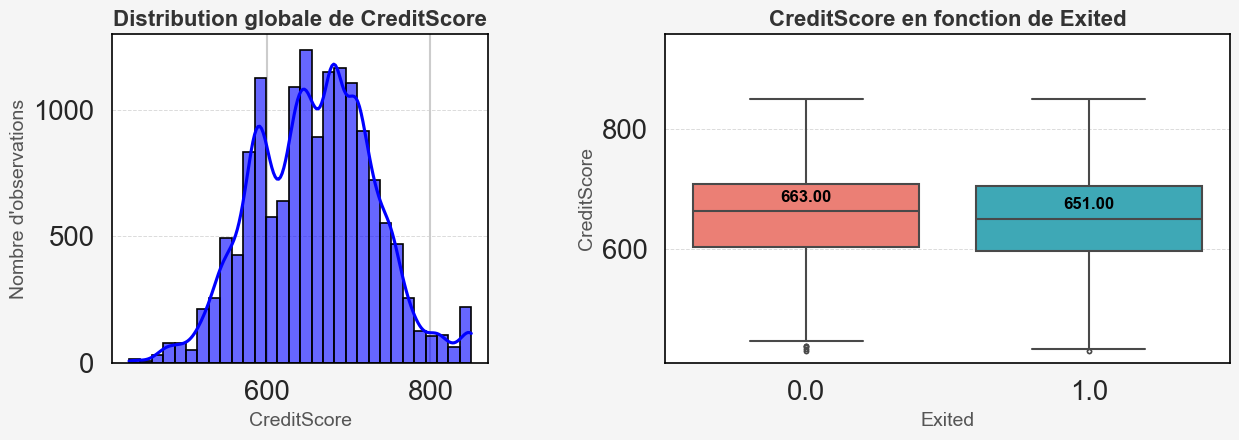

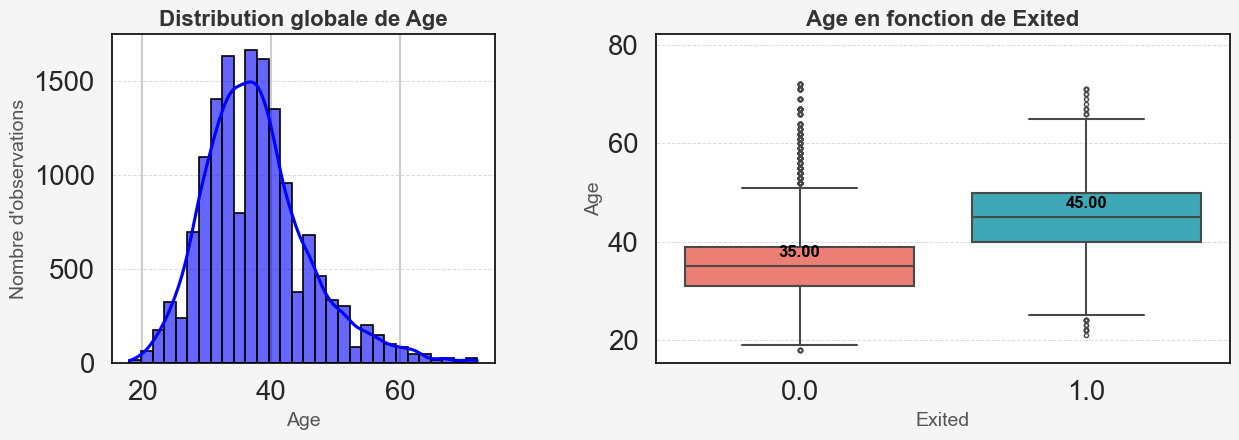

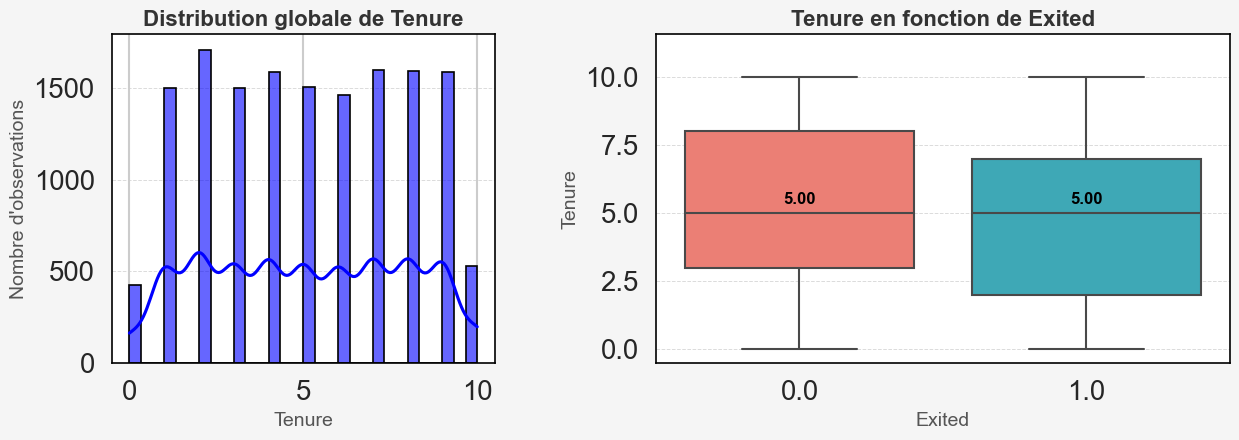

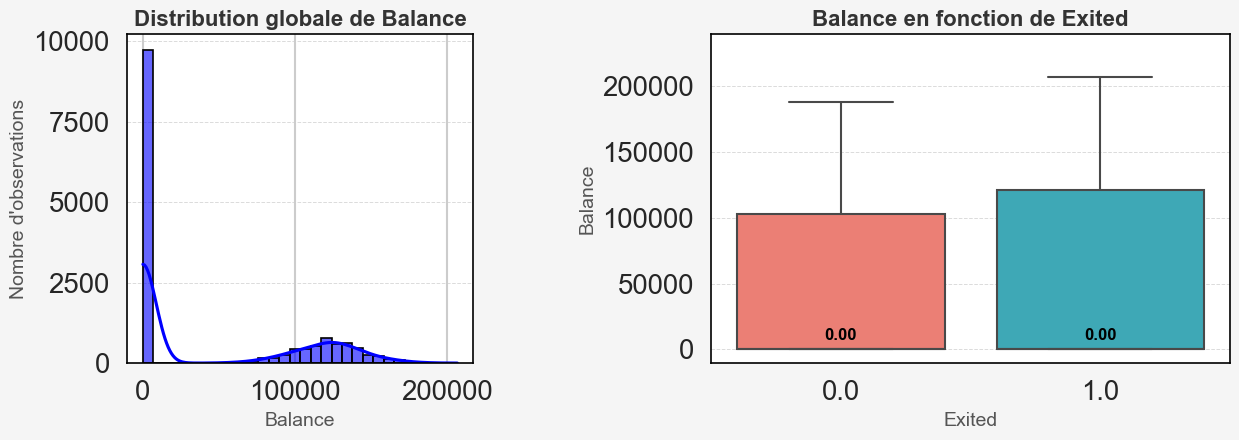

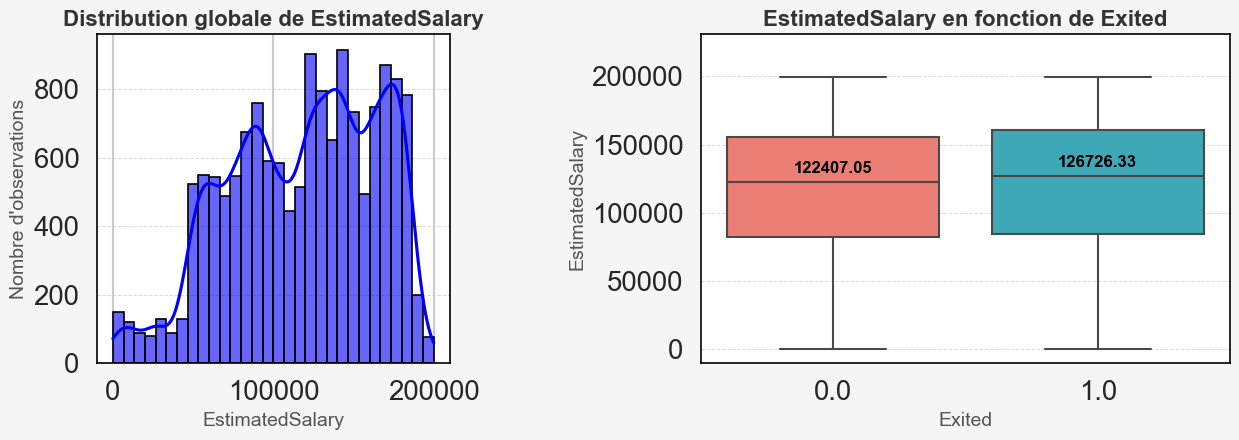

In [14]:
sns.set(style="whitegrid", context="talk", font_scale=1.2)
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.2

# Liste des variables numériques
var_num = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

palette_boxplot = ["#FF6F61", "#2AB7CA"]  

for col in var_num:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={"width_ratios": [2, 3]}, facecolor="#f5f5f5")
    
    # Distribution globale (avec KDE)
    sns.histplot(train[col], kde=True, color='blue', bins=30, alpha=0.6, ax=axes[0], edgecolor="black", linewidth=1.2)
    axes[0].set_title(f"Distribution globale de {col}", fontsize=16, fontweight="bold", color="#333333")
    axes[0].set_xlabel(col, fontsize=14, color="#555555")
    axes[0].set_ylabel("Nombre d'observations", fontsize=14, color="#555555")
    axes[0].grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
    
    # Distribution par cible (Boxplot)
    sns.boxplot(data=train, x='Exited', y=col, palette=palette_boxplot, ax=axes[1], linewidth=1.5, fliersize=3)
    axes[1].set_title(f"{col} en fonction de Exited", fontsize=16, fontweight="bold", color="#333333")
    axes[1].set_xlabel("Exited", fontsize=14, color="#555555")
    axes[1].set_ylabel(col, fontsize=14, color="#555555")
    axes[1].grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
    
    y_min, y_max = axes[1].get_ylim()
    axes[1].set_ylim(y_min, y_max + (0.1 * y_max))  
    mediane = train.groupby("Exited")[col].median()
    for i, median in enumerate(mediane):
        axes[1].annotate(f"{median:.2f}",
                         xy=(i, median),
                         xytext=(0, 10),  
                         textcoords="offset points",
                         ha='center', va='center',
                         color="black", fontsize=12, fontweight="bold")
    
    plt.tight_layout(pad=3.0)
    plt.show()

<h1 style="color: #FFFFFF; text-align: left; font-size: 2em;">
    📊 <strong>Interprétations des graphiques numériques</strong>
</h1>

<h3 style="color: #FFFFFF; text-align: left; font-size: 1.5em;">
    <span style="color: #00FA9A;">CreditScore</span>
</h3>
<p style="color: #FFFFFF; font-size: 1.1em;">
    La variable présente une distribution normale avec une légère asymétrie à gauche. Les différences entre les groupes <strong>Exited</strong> sont faibles, ce qui ne justifie ni transformation ni catégorisation. Elle est conservée telle quelle pour capturer toute l’information disponible.
</p>

---

<h3 style="color: #FFFFFF; text-align: left; font-size: 1.5em;">
    <span style="color: #00FA9A;">Tenure</span>
</h3>
<p style="color: #FFFFFF; font-size: 1.1em;">
    La variable est discrète avec des valeurs allant de 0 à 10 ans. Aucune relation significative avec le churn n’a été identifiée, mais elle est conservée telle quelle pour permettre aux modèles d’évaluer son importance.
</p>

---

<h3 style="color: #FFFFFF; text-align: left; font-size: 1.5em;">
    <span style="color: #00FA9A;">EstimatedSalary</span>
</h3>
<p style="color: #FFFFFF; font-size: 1.1em;">
    La distribution est uniforme et aucune relation claire avec le churn n’a été identifiée. Elle est conservée telle quelle pour laisser les modèles évaluer sa pertinence sans transformation spécifique.
</p>

---

<h3 style="color: #FFFFFF; text-align: left; font-size: 1.5em;">
    <span style="color: #00FA9A;">Balance</span>
</h3>
<p style="color: #FFFFFF; font-size: 1.1em;">
    Un grand nombre de clients ont un solde nul, ce qui peut indiquer une relation importante avec le churn. Une variable binaire sera ajoutée pour indiquer si le solde est nul, tout en gardant la version continue pour capturer les variations.
</p>Un grand nombre de clients ont un solde nul, ce qui peut indiquer une relation importante avec le churn. Une variable binaire sera ajoutée pour indiquer si le solde est nul, tout en gardant la version continue pour capturer les variations.

In [15]:
# --- Création de NoBalance ---
train['NoBalance'] = (train['Balance'] == 0).astype(int)
test['NoBalance'] = (test['Balance'] == 0).astype(int)

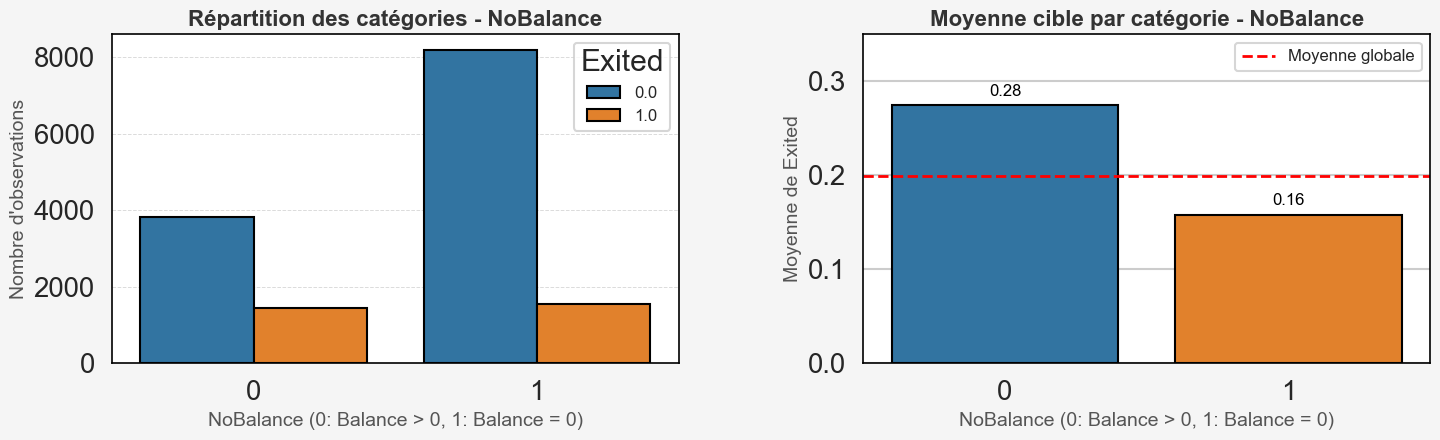

In [16]:
sns.set(style="whitegrid", context="talk", font_scale=1.2)
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.2

# Moyenne globale de la cible
moyenne_churn = train['Exited'].mean()

fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [2, 2]}, facecolor="#f5f5f5")

# Graphique 1 : Répartition de NoBalance
ax1 = axes[0]
palette = ['#1f77b4', '#ff7f0e']
sns.countplot(data=train, x='NoBalance', hue='Exited', palette=palette, ax=ax1, linewidth=1.5, edgecolor="black")
ax1.set_title("Répartition des catégories - NoBalance", fontsize=16, fontweight="bold", color="#333333")
ax1.set_xlabel("NoBalance (0: Balance > 0, 1: Balance = 0)", fontsize=14, color="#555555")
ax1.set_ylabel("Nombre d'observations", fontsize=14, color="#555555")
ax1.legend(title="Exited", fontsize=12, loc="upper right", fancybox=True)
ax1.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Graphique 2 : Moyenne cible pour NoBalance
ax2 = axes[1]
moyenne_categorielle = train.groupby('NoBalance')['Exited'].mean()
sns.barplot(x=moyenne_categorielle.index, y=moyenne_categorielle.values, palette=palette, ax=ax2, edgecolor="black")
ax2.axhline(moyenne_churn, color='red', linestyle='--', linewidth=2, label='Moyenne globale')
ax2.set_title("Moyenne cible par catégorie - NoBalance", fontsize=16, fontweight="bold", color="#333333")
ax2.set_xlabel("NoBalance (0: Balance > 0, 1: Balance = 0)", fontsize=14, color="#555555")
ax2.set_ylabel("Moyenne de Exited", fontsize=14, color="#555555")
ax2.legend(fontsize=12, loc="upper right", fancybox=True)

ax2.set_ylim(0, 0.35)  

for p in ax2.patches:
    ax2.annotate(format(p.get_height(), '.2f'),
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black',
                 xytext=(0, 10), textcoords='offset points')

plt.tight_layout(pad=3.0)
plt.show()


---

<h3 style="color: #FFFFFF; text-align: left; font-size: 1.5em;">
    <span style="color: #00FA9A;">Age</span>
</h3>
<p style="color: #FFFFFF; font-size: 1.1em;">
    Les clients plus âgés sont plus susceptibles de quitter la banque, comme l’indique une nette différence entre les distributions par cible. Une catégorisation (binning) sera effectuée pour capturer des effets non linéaires, tout en conservant la version continue.
</p>

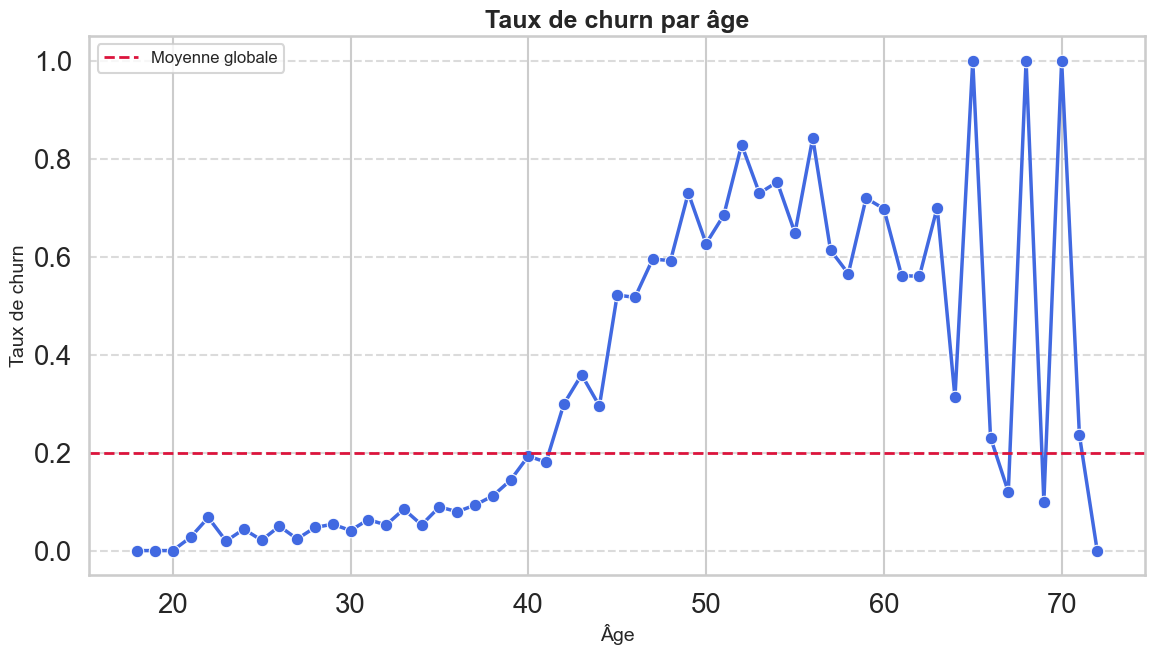

In [17]:
# Analyse du churn moyen par âge
age_churn = train.groupby('Age')['Exited'].mean().reset_index()

sns.set(style="whitegrid", context="talk", font_scale=1.2)

plt.figure(figsize=(12, 7))
sns.lineplot(data=age_churn, x='Age', y='Exited', marker="o", color="royalblue", linewidth=2.5)
plt.axhline(y=train['Exited'].mean(), color="crimson", linestyle="--", linewidth=2, label="Moyenne globale")

plt.title("Taux de churn par âge", fontsize=18, fontweight="bold")
plt.xlabel("Âge", fontsize=14)
plt.ylabel("Taux de churn", fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=12, loc="upper left")
plt.tight_layout()
plt.show()

<h3 style="font-family: 'Arial Black'; color: #FFFFFF; text-align: left; font-size: 1.5em;">
    📈 <span style="font-family: 'Arial'; color: #FFFFFF;">
        Le graphique révèle une <span style="color: #FFD700; font-weight: bold;">tendance croissante</span> du taux de churn avec l’âge, 
        marquée à partir de <span style="color: #00FA9A; font-weight: bold;">40 ans</span>. 
        Les clients plus âgés (<span style="color: #FF6347; font-weight: bold;">60 ans et plus</span>) présentent un taux de churn 
        <span style="color: #FF4500; font-weight: bold;">largement supérieur</span> à la moyenne globale (<span style="text-decoration: underline; color: #FFFFFF;">ligne rouge</span>), 
        signalant une vulnérabilité accrue de ce groupe.
    </span>
</h3>

In [18]:
# --- Binning de Age ---
def categorisation_age(age):
    if age <= 30:
        return "18-30"
    elif age <= 40:
        return "31-40"
    elif age <= 50:
        return "41-50"
    elif age <= 60:
        return "51-60"
    else:
        return "61+"

train["Age_bin"] = train["Age"].apply(categorisation_age)
test["Age_bin"] = test["Age"].apply(categorisation_age)

print(train["Age_bin"].value_counts())

Age_bin
31-40    7868
41-50    3411
18-30    2617
51-60     887
61+       217
Name: count, dtype: int64


<h3 style="font-family: 'Arial Black'; color: #FFFFFF; text-align: left; font-size: 1.5em;">
    📊 <span style="font-family: 'Arial'; color: #FFFFFF;">
        La décision de biner l’âge répond à l’observation de <span style="color: #FFD700; font-weight: bold;">variations non linéaires</span> dans le churn. 
        Cela permet de simplifier les groupes d’âge tout en mettant en lumière des segments spécifiques tels que 
        <span style="color: #00FA9A; font-weight: bold;">18-30 ans (jeunes adultes)</span> et <span style="color: #FF6347; font-weight: bold;">60 ans et plus</span>, 
        qui présentent des comportements distincts. Ce choix améliore l’interprétation des modèles et la <span style="color: #1E90FF; font-weight: bold;">captation des risques</span> par catégorie.
    </span>
</h3>

<Figure size 1200x600 with 0 Axes>

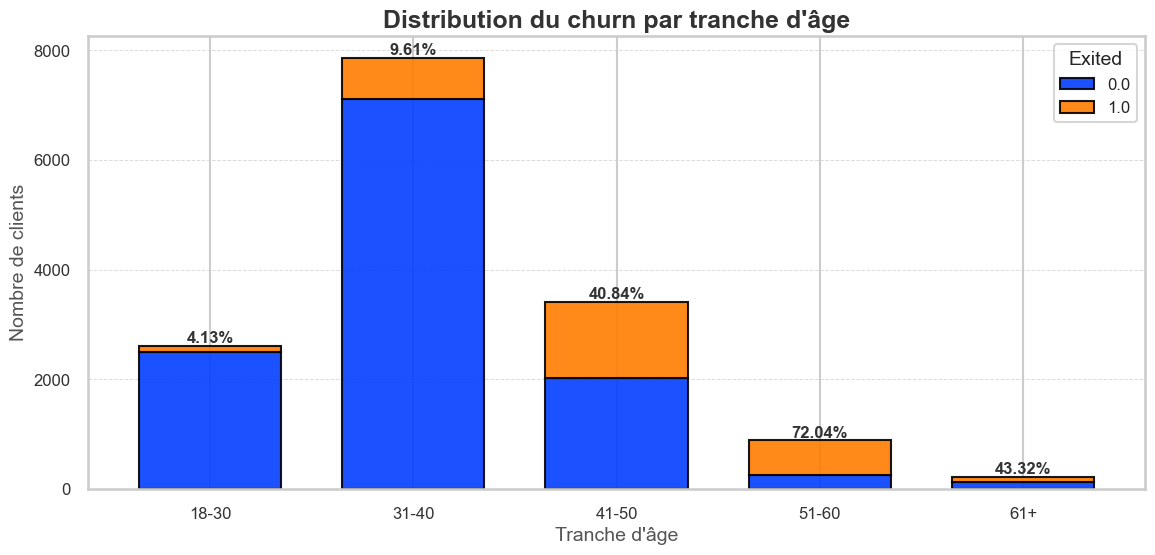

In [19]:
sns.set_palette("bright")

# Création d'une table croisée pour le churn par catégorie d'âge
age_churn_crosstab = pd.crosstab(train["Age_bin"], train["Exited"])

# Calcul des pourcentages de churn (Exited = 1) pour chaque tranche d'âge
pourcentage_churn = (age_churn_crosstab[1] / age_churn_crosstab.sum(axis=1)) * 100

# Tracé du graphique en barres empilées
plt.figure(figsize=(12, 6))
ax = age_churn_crosstab.plot(
    kind="bar", stacked=True, figsize=(12, 6), width=0.7, edgecolor="black", alpha=0.9
)

plt.title("Distribution du churn par tranche d'âge", fontsize=18, fontweight="bold", color="#333333")
plt.xlabel("Tranche d'âge", fontsize=14, color="#555555")
plt.ylabel("Nombre de clients", fontsize=14, color="#555555")

plt.xticks(rotation=0, fontsize=12, color="#333333")
plt.yticks(fontsize=12, color="#333333")
plt.grid(axis="y", linestyle="--", alpha=0.7, linewidth=0.7)

for i, pourcentage in enumerate(pourcentage_churn):
    somme_totale = age_churn_crosstab.sum(axis=1).iloc[i]
    plt.text(
        i, somme_totale, f"{pourcentage:.2f}%", 
        ha="center", va="bottom", fontsize=12, fontweight="bold", color="#333333"
    )
plt.legend(title="Exited", loc="upper right", fontsize=12, title_fontsize=14, fancybox=True)

plt.tight_layout()
plt.show()

<h3 style="font-family: 'Arial Black'; color: #00FA9A; text-align: left; font-size: 1.7em; border-bottom: 2px solid #00FA9A; padding-bottom: 5px;">
📊 Distribution du churn par tranche d'âge
</h3>
<p style="font-family: 'Arial'; color: #FFFFFF; line-height: 1.8; font-size: 1.1em;">
Le graphique ci-dessus met en évidence la proportion de clients quittant la banque (<span style="color: #FF6347; font-weight: bold;">churn</span>) par tranche d'âge. Les segments d'âge <span style="color: #00FA9A; font-weight: bold;">41-50 ans</span>, <span style="color: #00FA9A; font-weight: bold;">51-60 ans</span> et <span style="color: #00FA9A; font-weight: bold;">61+</span> sont particulièrement à risque, avec des taux de churn respectifs de <span style="color: #FF6347; font-weight: bold;">40.84%</span>, <span style="color: #FF6347; font-weight: bold;">72.04%</span> et <span style="color: #FF6347; font-weight: bold;">43.32%</span>. 
</p>

<h3 style="font-family: 'Arial Black'; color: #00FA9A; text-align: left; font-size: 1.7em; border-bottom: 2px solid #00FA9A; padding-bottom: 5px; margin-top: 20px;">
📌 Interprétation
</h3>
<p style="font-family: 'Arial'; color: #FFFFFF; line-height: 1.8; font-size: 1.1em;">
La tranche d'âge <span style="color: #00FA9A; font-weight: bold;">41-50 ans</span> affiche un churn significativement élevé. Ces résultats suggèrent que les clients de ces tranches, souvent actifs professionnellement, peuvent être plus sensibles à des offres compétitives ou insatisfaits des services actuels. Les tranches plus âgées (<span style="color: #00FA9A; font-weight: bold;">51-60 ans</span>) montrent des taux de churn extrêmes (<span style="color: #FF6347; font-weight: bold;">72.04%</span>), reflétant peut-être des facteurs comme la retraite ou des priorités financières différentes.
</p>


<h1 style="font-family: 'Arial Black'; color: #1E90FF; text-align: center; font-size: 3em; 
    background: -webkit-linear-gradient(#1E90FF, #00FA9A); -webkit-background-clip: text; -webkit-text-fill-color: transparent;">
    🛠️ Encodage des variables catégorielles
</h1>

In [20]:
col_cat = ['Geography', 'Gender', 'Age_bin']

# One-Hot Encoding sur le train
encoder = OneHotEncoder(drop='first', sparse_output=False) 
colonnes_encodees = pd.DataFrame(encoder.fit_transform(train[col_cat]),
                            columns=encoder.get_feature_names_out(col_cat))

# Ajout des colonnes encodées au dataset
train = pd.concat([train.drop(columns=col_cat), colonnes_encodees], axis=1)

print(train.head())


   CreditScore   Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0        683.0  49.0     7.0  123837.86            2.0        1.0   
1        608.0  30.0    10.0       0.00            2.0        1.0   
2        539.0  32.0     8.0       0.00            1.0        1.0   
3        530.0  39.0     8.0       0.00            2.0        0.0   
4        613.0  45.0    10.0       0.00            2.0        1.0   

   IsActiveMember  EstimatedSalary  Exited  NoBalance  Geography_Germany  \
0             1.0        138700.75     1.0          0                1.0   
1             1.0        146723.72     0.0          1                0.0   
2             1.0         94873.60     0.0          1                0.0   
3             0.0        177896.93     0.0          1                0.0   
4             1.0        116748.14     0.0          1                0.0   

   Geography_Spain  Gender_Male  Age_bin_31-40  Age_bin_41-50  Age_bin_51-60  \
0              0.0          1.0            0.0  

In [21]:
# ... sur le test
test = pd.concat([test.drop(columns=col_cat),
                          pd.DataFrame(encoder.transform(test[col_cat]),
                                       columns=encoder.get_feature_names_out(col_cat))],
                         axis=1)

In [22]:
print("\nTypes des variables pour train :")
print(train.dtypes)


Types des variables pour train :
CreditScore          float64
Age                  float64
Tenure               float64
Balance              float64
NumOfProducts        float64
HasCrCard            float64
IsActiveMember       float64
EstimatedSalary      float64
Exited               float64
NoBalance              int32
Geography_Germany    float64
Geography_Spain      float64
Gender_Male          float64
Age_bin_31-40        float64
Age_bin_41-50        float64
Age_bin_51-60        float64
Age_bin_61+          float64
dtype: object


<h1 style="font-family: 'Arial Black'; color: #1E90FF; text-align: center; font-size: 3em; 
    background: -webkit-linear-gradient(#1E90FF, #00FA9A); -webkit-background-clip: text; -webkit-text-fill-color: transparent;">
    🔍 Analyse de la matrice de corrélation
</h1>

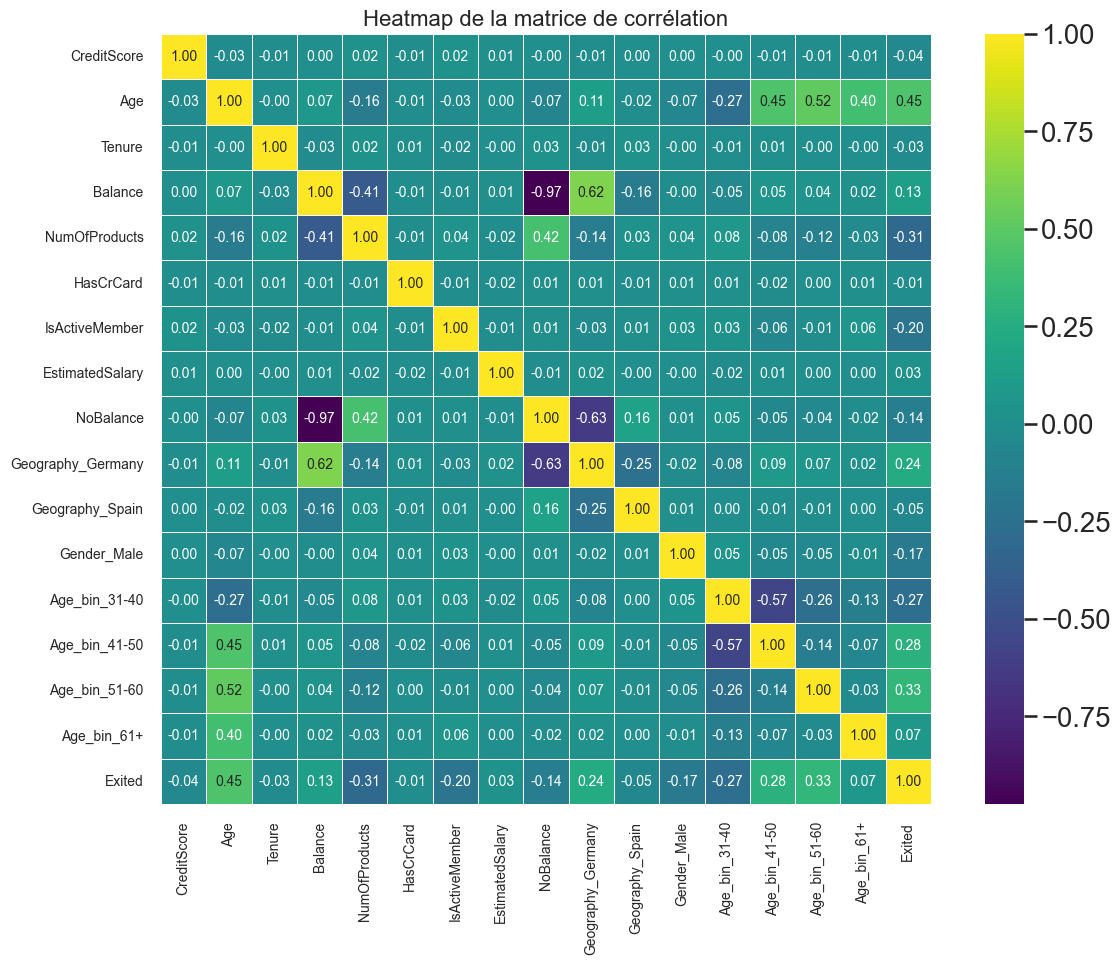

In [23]:
# Calcul de la matrice de corrélation
matrice_de_correlation = train.corr()
columns = [col for col in matrice_de_correlation.columns if col != "Exited"] + ["Exited"]
matrice_de_correlation = matrice_de_correlation[columns]  
matrice_de_correlation = matrice_de_correlation.loc[columns] 

plt.figure(figsize=(14, 10))  
sns.heatmap(matrice_de_correlation, annot=True, fmt=".2f", cmap="viridis", cbar=True, square=True, linewidths=0.5, annot_kws={"size": 10})
plt.title("Heatmap de la matrice de corrélation", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

<h3 style="font-family: 'Arial Black'; color: #FFFFFF; text-align: left; font-size: 1.5em; border-bottom: 2px solid #00FA9A; padding-bottom: 5px; display: inline-block;">
🔍 Interprétation détaillée de la matrice de corrélation
</h3>
<p style="font-family: 'Arial'; color: #FFFFFF;">
✔️ Une corrélation <span style="color: #FF6347; font-weight: bold;">négative forte</span> est observée entre <span style="color: #00FA9A; font-weight: bold;">Balance</span> et <span style="color: #00FA9A; font-weight: bold;">NoBalance</span> (<span style="color: #FF6347;">-0.97</span>), ce qui est attendu puisque ces deux variables sont définies de manière inverse (solde nul vs solde positif).
</p>
<p style="font-family: 'Arial'; color: #FFFFFF;">
✔️ La variable <span style="color: #FFD700; font-weight: bold;">Exited</span> (<span style="color: #FF6347; font-weight: bold;">churn</span>) montre une corrélation <span style="color: #00FA9A; font-weight: bold;">modérément positive</span> avec <span style="color: #00FA9A; font-weight: bold;">Age_bin_41-50</span> (<span style="color: #FF6347; font-weight: bold;">0.28</span>) et <span style="color: #00FA9A; font-weight: bold;">Age_bin_51-60</span> (<span style="color: #FF6347; font-weight: bold;">0.33</span>), indiquant que les clients plus âgés sont plus susceptibles de quitter la banque.
</p>
<p style="font-family: 'Arial'; color: #FFFFFF;">
✔️ Une corrélation notable est aussi visible entre <span style="color: #00FA9A; font-weight: bold;">Geography_Germany</span> et <span style="color: #FFD700; font-weight: bold;">Exited</span> (<span style="color: #FF6347; font-weight: bold;">0.24</span>), suggérant que les clients en Allemagne sont davantage enclins au churn.
</p>
<p style="font-family: 'Arial'; color: #FFFFFF;">
✔️ À l’inverse, <span style="color: #00FA9A; font-weight: bold;">IsActiveMember</span> présente une <span style="color: #FF6347; font-weight: bold;">corrélation négative</span> avec <span style="color: #FFD700; font-weight: bold;">Exited</span> (<span style="color: #FF6347; font-weight: bold;">-0.20</span>), confirmant que les membres actifs sont moins susceptibles de quitter la banque.
</p>
<p style="font-family: 'Arial'; color: #FFFFFF;">
✔️ <span style="color: #00FA9A; font-weight: bold;">NumOfProducts</span> montre une <span style="color: #FF6347; font-weight: bold;">corrélation modérément négative</span> avec <span style="color: #FFD700; font-weight: bold;">Exited</span> (<span style="color: #FF6347; font-weight: bold;">-0.31</span>), ce qui indique que les clients avec plus de produits sont moins susceptibles de quitter la banque. Cependant, cela pourrait refléter une relation complexe nécessitant une analyse approfondie.
</p>
<p style="font-family: 'Arial'; color: #FFFFFF;">
💡 En résumé, les corrélations importantes mettent en lumière des relations entre certaines caractéristiques clés (âge, nombre de produits, activité, géographie) et le churn, offrant des pistes pour mieux cibler les actions de rétention.
</p>

<h1 style="font-family: 'Arial Black'; color: #1E90FF; text-align: center; font-size: 3em; 
    background: -webkit-linear-gradient(#1E90FF, #00FA9A); -webkit-background-clip: text; -webkit-text-fill-color: transparent;">
    🚀 Modélisation : CatBoost
</h1>

<h3 style="font-family: 'Arial Black'; color: #00FA9A; text-align: left; font-size: 1.5em;">
⓵ Étape 1 : Création de la validation fixe et des folds stratifiés
</h3>

<h3 style="font-family: 'Arial Black'; color: #FFFFFF; text-align: left; font-size: 1.5em;">
🛠️ Préparation des données pour une validation robuste
</h3>
<p style="font-family: 'Arial'; color: #FFFFFF;">
✔️ Une <span style="color: #00FA9A; font-weight: bold;">validation fixe indépendante</span> a été mise en place, divisant les données en :  
   
- Un ensemble d’entraînement (<span style="color: #FFD700; font-weight: bold;">train_data de 80%</span>) pour ajuster le modèle.  
- Un ensemble de validation fixe (<span style="color: #FFD700; font-weight: bold;">val_data de 20%</span>) pour évaluer les performances sur des données non vues.  
</p>
<p style="font-family: 'Arial'; color: #FFFFFF;">
✔️ Des <span style="color: #00FA9A; font-weight: bold;">folds stratifiés</span> ont été créés sur les 80% (<span style="color: #FFD700; font-weight: bold;">train_data</span>) grâce à la méthode <i>StratifiedKFold</i>, garantissant :  

- Une répartition équilibrée des classes de la cible (<span style="color: #FF6347; font-weight: bold;">Exited</span>) dans chaque fold.  
- Une validation croisée fiable pour tester la stabilité et la performance du modèle.  
</p>
<p style="font-family: 'Arial'; color: #FFFFFF;">
💡 <span style="color: #FFD700; font-weight: bold;">En résumé</span>, cette double stratégie optimise l’évaluation du modèle en réduisant les biais liés à l’<span style="color: #00FA9A; font-weight: bold;">équilibre des classes</span> et en exploitant efficacement les données disponibles.
</p>

In [24]:
train_data, val_data = train_test_split(train, test_size=0.2, stratify=train['Exited'], random_state=42)

# Validation fixe indépendante
X_val_fixe = val_data.drop(columns=["Exited"])
y_val_fixe = val_data["Exited"]

nb_split = 5
skf = StratifiedKFold(n_splits=nb_split, shuffle=True, random_state=42)
train_data["fold"] = -1  # Initialisation de la colonne pour les folds

for fold, (train_idx, val_idx) in enumerate(skf.split(train_data, train_data["Exited"])):
    train_data.loc[train_data.index[val_idx], "fold"] = fold

print("\nRépartition des folds dans train_data :")
print(train_data["fold"].value_counts())
print("\nRépartition des classes par fold :")
print(pd.crosstab(train_data["fold"], train_data["Exited"]))


Répartition des folds dans train_data :
fold
1    2400
2    2400
4    2400
3    2400
0    2400
Name: count, dtype: int64

Répartition des classes par fold :
Exited   0.0  1.0
fold             
0       1922  478
1       1922  478
2       1922  478
3       1921  479
4       1921  479


<h3 style="font-family: 'Arial Black'; color: #00FA9A; text-align: left; font-size: 1.5em;">
⓶ Étape 2 : Optimisation des hyperparamètres de CatBoost avec Optuna ⚙️
</h3>

📌 **Optuna** est une bibliothèque puissante dédiée à l'optimisation des hyperparamètres grâce à des algorithmes de recherche efficaces, comme le TPE (Tree-structured Parzen Estimator).  
Dans ce code, Optuna explore automatiquement différentes combinaisons d'hyperparamètres pour le modèle **CatBoost**, en utilisant la validation croisée pour maximiser l'AUC tout en pénalisant la variabilité des scores entre les folds.

In [25]:
# Création d'une fonction objective pour Optuna
def fonction_objective_catboost(trial):
    # Définition des hyperparamètres à optimiser
    params = {
        "iterations": trial.suggest_int("iterations", 100, 500),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.05, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 20, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),
        "random_state": 42
    }

    # Validation croisée sur les folds (créés plus haut avec StratifiedKFold)
    auc_scores = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(train_data, train_data["Exited"])):
        train_fold = train_data.iloc[train_idx]
        val_fold = train_data.iloc[val_idx]
        X_train_fold = train_fold.drop(columns=["Exited", "fold"])
        y_train_fold = train_fold["Exited"]
        X_val_fold = val_fold.drop(columns=["Exited", "fold"])
        y_val_fold = val_fold["Exited"]

        # Entraînement du modèle
        model_cb = CatBoostClassifier(**params, verbose=0)
        model_cb.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold), use_best_model=True)

        # Calcul de l'AUC pour le fold actuel
        y_val_pred = model_cb.predict_proba(X_val_fold)[:, 1]
        auc = roc_auc_score(y_val_fold, y_val_pred)
        auc_scores.append(auc)

    # Évaluation sur l'ensemble de validation  fixe
    y_val_fixe_pred = model_cb.predict_proba(X_val_fixe)[:, 1]
    auc_fixe = roc_auc_score(y_val_fixe, y_val_fixe_pred)

    # Pénalité basée sur la variabilité des scores AUC des folds
    penalite = 0 if np.std(auc_scores) < 0.01 else np.std(auc_scores)
    print(f"AUC Fixe : {auc_fixe:.4f}, Variabilité des folds : {penalite:.4f}")

    # Objectif d'Optuna : Maximiser la moyenne des AUC des folds, pénalisée par la variabilité
    return np.mean(auc_scores) - penalite

# Optimisation avec Optuna
study_cb = optuna.create_study(direction="maximize", study_name="Optimisation CatBoost")
study_cb.optimize(fonction_objective_catboost, n_trials=100, n_jobs=-1)

# Résultats de l'optimisation
print("\nMeilleurs hyperparamètres :")
print(study_cb.best_params)
print(f"Meilleur score AUC moyen sur validation : {study_cb.best_value:.4f}")

[I 2025-01-02 12:59:39,338] A new study created in memory with name: Optimisation CatBoost
[I 2025-01-02 12:59:43,815] Trial 0 finished with value: 0.9348324399727355 and parameters: {'iterations': 131, 'depth': 4, 'learning_rate': 0.03383137792753434, 'l2_leaf_reg': 9.21512501798578, 'bagging_temperature': 0.9201896984623755}. Best is trial 0 with value: 0.9348324399727355.


AUC Fixe : 0.9298, Variabilité des folds : 0.0000


[I 2025-01-02 12:59:45,358] Trial 15 finished with value: 0.9271311439828784 and parameters: {'iterations': 110, 'depth': 6, 'learning_rate': 0.005771595915307593, 'l2_leaf_reg': 1.2541287927416511, 'bagging_temperature': 0.6034513826965039}. Best is trial 0 with value: 0.9348324399727355.


AUC Fixe : 0.9225, Variabilité des folds : 0.0000


[I 2025-01-02 12:59:45,888] Trial 6 finished with value: 0.9264436212174905 and parameters: {'iterations': 116, 'depth': 6, 'learning_rate': 0.007525933576540634, 'l2_leaf_reg': 15.355210003144064, 'bagging_temperature': 0.587804772808227}. Best is trial 0 with value: 0.9348324399727355.


AUC Fixe : 0.9196, Variabilité des folds : 0.0000


[I 2025-01-02 12:59:46,406] Trial 2 finished with value: 0.9357953635780264 and parameters: {'iterations': 173, 'depth': 5, 'learning_rate': 0.026262831665139902, 'l2_leaf_reg': 7.159397275361606, 'bagging_temperature': 0.9037244680446311}. Best is trial 2 with value: 0.9357953635780264.


AUC Fixe : 0.9309, Variabilité des folds : 0.0000


[I 2025-01-02 12:59:50,084] Trial 8 finished with value: 0.9276524728420483 and parameters: {'iterations': 108, 'depth': 8, 'learning_rate': 0.0065595343202803766, 'l2_leaf_reg': 14.861614337886266, 'bagging_temperature': 0.616608476520891}. Best is trial 2 with value: 0.9357953635780264.


AUC Fixe : 0.9200, Variabilité des folds : 0.0000


[I 2025-01-02 12:59:50,604] Trial 4 finished with value: 0.937940904893819 and parameters: {'iterations': 255, 'depth': 4, 'learning_rate': 0.043474829573309726, 'l2_leaf_reg': 1.6749340107130317, 'bagging_temperature': 0.7174561936517074}. Best is trial 4 with value: 0.937940904893819.


AUC Fixe : 0.9340, Variabilité des folds : 0.0000


[I 2025-01-02 12:59:52,128] Trial 7 finished with value: 0.9319988445746585 and parameters: {'iterations': 134, 'depth': 8, 'learning_rate': 0.008564862332401309, 'l2_leaf_reg': 4.02408193052458, 'bagging_temperature': 0.156143592487348}. Best is trial 4 with value: 0.937940904893819.


AUC Fixe : 0.9265, Variabilité des folds : 0.0000


[I 2025-01-02 12:59:55,315] Trial 13 finished with value: 0.9376404581288856 and parameters: {'iterations': 289, 'depth': 6, 'learning_rate': 0.021772078487380865, 'l2_leaf_reg': 7.936466191885379, 'bagging_temperature': 0.0781294951284155}. Best is trial 4 with value: 0.937940904893819.


AUC Fixe : 0.9336, Variabilité des folds : 0.0000


[I 2025-01-02 12:59:57,073] Trial 19 finished with value: 0.9329753107975934 and parameters: {'iterations': 190, 'depth': 6, 'learning_rate': 0.010359068763350729, 'l2_leaf_reg': 1.4924417116631215, 'bagging_temperature': 0.5890317825695268}. Best is trial 4 with value: 0.937940904893819.


AUC Fixe : 0.9290, Variabilité des folds : 0.0000


[I 2025-01-02 12:59:57,812] Trial 11 finished with value: 0.9363912686111867 and parameters: {'iterations': 413, 'depth': 5, 'learning_rate': 0.007749751341496485, 'l2_leaf_reg': 4.330625985338036, 'bagging_temperature': 0.6306997254928736}. Best is trial 4 with value: 0.937940904893819.


AUC Fixe : 0.9317, Variabilité des folds : 0.0000


[I 2025-01-02 13:00:01,626] Trial 14 finished with value: 0.9319661720988991 and parameters: {'iterations': 141, 'depth': 9, 'learning_rate': 0.0077215042225613865, 'l2_leaf_reg': 3.984722395218687, 'bagging_temperature': 0.528912179420741}. Best is trial 4 with value: 0.937940904893819.


AUC Fixe : 0.9263, Variabilité des folds : 0.0000


[I 2025-01-02 13:00:04,983] Trial 22 finished with value: 0.9355929446591865 and parameters: {'iterations': 304, 'depth': 4, 'learning_rate': 0.01073003417055387, 'l2_leaf_reg': 2.871787992869775, 'bagging_temperature': 0.7115119805170066}. Best is trial 4 with value: 0.937940904893819.


AUC Fixe : 0.9307, Variabilité des folds : 0.0000


[I 2025-01-02 13:00:09,424] Trial 12 finished with value: 0.9371591289566744 and parameters: {'iterations': 256, 'depth': 8, 'learning_rate': 0.03112913145922618, 'l2_leaf_reg': 17.55213958767918, 'bagging_temperature': 0.7815772034472702}. Best is trial 4 with value: 0.937940904893819.


AUC Fixe : 0.9321, Variabilité des folds : 0.0000


[I 2025-01-02 13:00:14,009] Trial 3 finished with value: 0.9371853440942208 and parameters: {'iterations': 334, 'depth': 7, 'learning_rate': 0.017015120299506532, 'l2_leaf_reg': 13.568119234448499, 'bagging_temperature': 0.8192159439256851}. Best is trial 4 with value: 0.937940904893819.


AUC Fixe : 0.9334, Variabilité des folds : 0.0000


[I 2025-01-02 13:00:16,659] Trial 1 finished with value: 0.930656506121036 and parameters: {'iterations': 172, 'depth': 9, 'learning_rate': 0.005290114884228895, 'l2_leaf_reg': 7.568889368745768, 'bagging_temperature': 0.42021701825464475}. Best is trial 4 with value: 0.937940904893819.


AUC Fixe : 0.9243, Variabilité des folds : 0.0000


[I 2025-01-02 13:00:21,199] Trial 24 finished with value: 0.9325659121138518 and parameters: {'iterations': 265, 'depth': 4, 'learning_rate': 0.007044965827413328, 'l2_leaf_reg': 15.421293457480552, 'bagging_temperature': 0.14207373327864614}. Best is trial 4 with value: 0.937940904893819.


AUC Fixe : 0.9275, Variabilité des folds : 0.0000


[I 2025-01-02 13:00:35,123] Trial 26 finished with value: 0.9377377656355435 and parameters: {'iterations': 285, 'depth': 4, 'learning_rate': 0.04967818244229313, 'l2_leaf_reg': 2.170274010443567, 'bagging_temperature': 0.0775164137081189}. Best is trial 4 with value: 0.937940904893819.


AUC Fixe : 0.9338, Variabilité des folds : 0.0000


[I 2025-01-02 13:00:54,942] Trial 9 finished with value: 0.9367964998480257 and parameters: {'iterations': 371, 'depth': 8, 'learning_rate': 0.02999911736014829, 'l2_leaf_reg': 3.2675529393346188, 'bagging_temperature': 0.8942491021730149}. Best is trial 4 with value: 0.937940904893819.


AUC Fixe : 0.9313, Variabilité des folds : 0.0000


[I 2025-01-02 13:01:16,236] Trial 30 finished with value: 0.9376985805681468 and parameters: {'iterations': 375, 'depth': 5, 'learning_rate': 0.04736346236885221, 'l2_leaf_reg': 2.06553760599742, 'bagging_temperature': 0.016171084790688628}. Best is trial 4 with value: 0.937940904893819.


AUC Fixe : 0.9335, Variabilité des folds : 0.0000


[I 2025-01-02 13:01:19,080] Trial 23 finished with value: 0.9364971157296613 and parameters: {'iterations': 317, 'depth': 8, 'learning_rate': 0.047847336807235706, 'l2_leaf_reg': 1.0714221887431647, 'bagging_temperature': 0.8287571258956957}. Best is trial 4 with value: 0.937940904893819.


AUC Fixe : 0.9316, Variabilité des folds : 0.0000


[I 2025-01-02 13:01:19,714] Trial 31 finished with value: 0.9378063961041712 and parameters: {'iterations': 412, 'depth': 5, 'learning_rate': 0.044399026738999696, 'l2_leaf_reg': 2.072732361969118, 'bagging_temperature': 0.3682176223013564}. Best is trial 4 with value: 0.937940904893819.


AUC Fixe : 0.9341, Variabilité des folds : 0.0000


[I 2025-01-02 13:01:21,447] Trial 32 finished with value: 0.937734198302228 and parameters: {'iterations': 386, 'depth': 5, 'learning_rate': 0.04926591426750923, 'l2_leaf_reg': 1.97588824226167, 'bagging_temperature': 0.36697215117996307}. Best is trial 4 with value: 0.937940904893819.


AUC Fixe : 0.9332, Variabilité des folds : 0.0000


[I 2025-01-02 13:01:29,827] Trial 34 finished with value: 0.937849482951505 and parameters: {'iterations': 222, 'depth': 4, 'learning_rate': 0.04834503510496194, 'l2_leaf_reg': 1.9262361452562833, 'bagging_temperature': 0.3470229412065488}. Best is trial 4 with value: 0.937940904893819.


AUC Fixe : 0.9338, Variabilité des folds : 0.0000


[I 2025-01-02 13:01:33,352] Trial 33 finished with value: 0.9379824716347962 and parameters: {'iterations': 500, 'depth': 5, 'learning_rate': 0.04760832622101375, 'l2_leaf_reg': 1.957737387852767, 'bagging_temperature': 0.3432986224463425}. Best is trial 33 with value: 0.9379824716347962.


AUC Fixe : 0.9343, Variabilité des folds : 0.0000


[I 2025-01-02 13:01:46,405] Trial 37 finished with value: 0.9379288030133643 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.03786404740288932, 'l2_leaf_reg': 2.0170291570987793, 'bagging_temperature': 0.2900794698289926}. Best is trial 33 with value: 0.9379824716347962.


AUC Fixe : 0.9336, Variabilité des folds : 0.0000


[I 2025-01-02 13:01:52,163] Trial 36 finished with value: 0.9379022254870579 and parameters: {'iterations': 469, 'depth': 4, 'learning_rate': 0.03781276189157365, 'l2_leaf_reg': 1.967538588010589, 'bagging_temperature': 0.3469046358853552}. Best is trial 33 with value: 0.9379824716347962.


AUC Fixe : 0.9340, Variabilité des folds : 0.0000


[I 2025-01-02 13:02:15,990] Trial 5 finished with value: 0.9353643224952993 and parameters: {'iterations': 247, 'depth': 10, 'learning_rate': 0.0064960606922020115, 'l2_leaf_reg': 8.868978632251281, 'bagging_temperature': 0.5879456649711629}. Best is trial 33 with value: 0.9379824716347962.


AUC Fixe : 0.9312, Variabilité des folds : 0.0000


[I 2025-01-02 13:02:17,482] Trial 38 finished with value: 0.9378218471647835 and parameters: {'iterations': 487, 'depth': 4, 'learning_rate': 0.03853315781723869, 'l2_leaf_reg': 1.6823616110495239, 'bagging_temperature': 0.29525843106783684}. Best is trial 33 with value: 0.9379824716347962.


AUC Fixe : 0.9334, Variabilité des folds : 0.0000


[I 2025-01-02 13:02:20,262] Trial 39 finished with value: 0.9380836108238426 and parameters: {'iterations': 482, 'depth': 4, 'learning_rate': 0.03641136643902441, 'l2_leaf_reg': 1.5561773613836056, 'bagging_temperature': 0.25349810845144527}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9341, Variabilité des folds : 0.0000


[I 2025-01-02 13:02:34,020] Trial 10 finished with value: 0.9361208548981674 and parameters: {'iterations': 265, 'depth': 10, 'learning_rate': 0.018639171185855046, 'l2_leaf_reg': 3.1194083018804384, 'bagging_temperature': 0.6592394434656558}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9306, Variabilité des folds : 0.0000


[I 2025-01-02 13:02:40,744] Trial 40 finished with value: 0.9379011240385419 and parameters: {'iterations': 496, 'depth': 4, 'learning_rate': 0.03718357231066441, 'l2_leaf_reg': 1.468312350160306, 'bagging_temperature': 0.25174823719222783}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9340, Variabilité des folds : 0.0000


[I 2025-01-02 13:02:45,690] Trial 18 finished with value: 0.935368328062383 and parameters: {'iterations': 253, 'depth': 10, 'learning_rate': 0.030789923263389415, 'l2_leaf_reg': 1.8444857208193244, 'bagging_temperature': 0.43285932498445434}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9313, Variabilité des folds : 0.0000


[I 2025-01-02 13:02:56,427] Trial 44 finished with value: 0.9379111510436189 and parameters: {'iterations': 468, 'depth': 5, 'learning_rate': 0.02402367497418523, 'l2_leaf_reg': 2.6223439493504492, 'bagging_temperature': 0.9816712060849133}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9338, Variabilité des folds : 0.0000


[I 2025-01-02 13:02:58,239] Trial 29 finished with value: 0.9359379364217176 and parameters: {'iterations': 228, 'depth': 10, 'learning_rate': 0.020514754359764385, 'l2_leaf_reg': 1.982840493980312, 'bagging_temperature': 0.31297693594818626}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9312, Variabilité des folds : 0.0000


[I 2025-01-02 13:03:02,677] Trial 45 finished with value: 0.9377824454264289 and parameters: {'iterations': 465, 'depth': 5, 'learning_rate': 0.0245002968922474, 'l2_leaf_reg': 5.627251195124533, 'bagging_temperature': 0.47158522563674926}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9339, Variabilité des folds : 0.0000


[I 2025-01-02 13:03:05,596] Trial 43 finished with value: 0.9377329061284762 and parameters: {'iterations': 454, 'depth': 5, 'learning_rate': 0.019095831431924812, 'l2_leaf_reg': 2.733330416637915, 'bagging_temperature': 0.22520571254485555}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9336, Variabilité des folds : 0.0000


[I 2025-01-02 13:03:06,102] Trial 25 finished with value: 0.9361621152385216 and parameters: {'iterations': 288, 'depth': 10, 'learning_rate': 0.043200314508047684, 'l2_leaf_reg': 2.6137138883065836, 'bagging_temperature': 0.322109823950033}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9309, Variabilité des folds : 0.0000


[I 2025-01-02 13:03:07,277] Trial 42 finished with value: 0.9380086585492606 and parameters: {'iterations': 499, 'depth': 5, 'learning_rate': 0.02313234372597306, 'l2_leaf_reg': 1.4852486204115516, 'bagging_temperature': 0.2686529889743366}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9334, Variabilité des folds : 0.0000


[I 2025-01-02 13:03:14,203] Trial 27 finished with value: 0.9355324089136106 and parameters: {'iterations': 273, 'depth': 10, 'learning_rate': 0.04943579834475032, 'l2_leaf_reg': 2.133765701219568, 'bagging_temperature': 0.0016400939936019043}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9317, Variabilité des folds : 0.0000


[I 2025-01-02 13:03:14,534] Trial 46 finished with value: 0.9378302274593434 and parameters: {'iterations': 457, 'depth': 5, 'learning_rate': 0.025826548500481643, 'l2_leaf_reg': 2.6633587476699248, 'bagging_temperature': 0.46263381487534316}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9335, Variabilité des folds : 0.0000


[I 2025-01-02 13:03:35,452] Trial 48 finished with value: 0.9379330773718635 and parameters: {'iterations': 453, 'depth': 4, 'learning_rate': 0.03979637635600841, 'l2_leaf_reg': 1.020971189948053, 'bagging_temperature': 0.22315129735508965}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9339, Variabilité des folds : 0.0000


[I 2025-01-02 13:03:42,232] Trial 47 finished with value: 0.9376769438561736 and parameters: {'iterations': 447, 'depth': 5, 'learning_rate': 0.02555022939394087, 'l2_leaf_reg': 1.0325732652518058, 'bagging_temperature': 0.9985136417719339}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9335, Variabilité des folds : 0.0000


[I 2025-01-02 13:03:43,067] Trial 50 finished with value: 0.9378557959417385 and parameters: {'iterations': 437, 'depth': 4, 'learning_rate': 0.04046855361046289, 'l2_leaf_reg': 1.0235362924469236, 'bagging_temperature': 0.1851440827026597}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9338, Variabilité des folds : 0.0000


[I 2025-01-02 13:03:46,259] Trial 52 finished with value: 0.9372161270742172 and parameters: {'iterations': 436, 'depth': 4, 'learning_rate': 0.01381683141990361, 'l2_leaf_reg': 1.07569648101353, 'bagging_temperature': 0.23915237394595118}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9330, Variabilité des folds : 0.0000


[I 2025-01-02 13:03:48,127] Trial 49 finished with value: 0.9376555005443759 and parameters: {'iterations': 438, 'depth': 5, 'learning_rate': 0.04028888225119806, 'l2_leaf_reg': 1.0315742332484006, 'bagging_temperature': 0.44500229527495655}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9342, Variabilité des folds : 0.0000


[I 2025-01-02 13:03:49,094] Trial 28 finished with value: 0.935562535277667 and parameters: {'iterations': 327, 'depth': 10, 'learning_rate': 0.04930801310098964, 'l2_leaf_reg': 2.401306027150348, 'bagging_temperature': 0.32680076611453335}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9309, Variabilité des folds : 0.0000


[I 2025-01-02 13:03:50,051] Trial 51 finished with value: 0.9377384125758972 and parameters: {'iterations': 435, 'depth': 4, 'learning_rate': 0.040683003900250536, 'l2_leaf_reg': 1.1059374936727513, 'bagging_temperature': 0.21685932120820883}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9338, Variabilité des folds : 0.0000


[I 2025-01-02 13:04:01,135] Trial 20 finished with value: 0.9361421623363155 and parameters: {'iterations': 425, 'depth': 10, 'learning_rate': 0.008208858490646861, 'l2_leaf_reg': 3.923844758562582, 'bagging_temperature': 0.04589983317429658}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9322, Variabilité des folds : 0.0000


[I 2025-01-02 13:04:02,002] Trial 16 finished with value: 0.9353701113293317 and parameters: {'iterations': 375, 'depth': 10, 'learning_rate': 0.03254035835069216, 'l2_leaf_reg': 1.0955858557569906, 'bagging_temperature': 0.3273739606079388}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9309, Variabilité des folds : 0.0000


[I 2025-01-02 13:04:29,030] Trial 54 finished with value: 0.9371272522115905 and parameters: {'iterations': 435, 'depth': 7, 'learning_rate': 0.027286517507201572, 'l2_leaf_reg': 1.026684725959527, 'bagging_temperature': 0.19653602745338428}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9323, Variabilité des folds : 0.0000


[I 2025-01-02 13:04:30,070] Trial 55 finished with value: 0.9370996783852206 and parameters: {'iterations': 442, 'depth': 7, 'learning_rate': 0.01485179856530509, 'l2_leaf_reg': 1.0489763449687257, 'bagging_temperature': 0.19879336535403713}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9330, Variabilité des folds : 0.0000


[I 2025-01-02 13:04:33,330] Trial 58 finished with value: 0.9379744394467593 and parameters: {'iterations': 415, 'depth': 6, 'learning_rate': 0.03426818400175337, 'l2_leaf_reg': 1.2373986235134569, 'bagging_temperature': 0.20950096253399095}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9327, Variabilité des folds : 0.0000


[I 2025-01-02 13:04:34,305] Trial 53 finished with value: 0.9372647099586736 and parameters: {'iterations': 437, 'depth': 7, 'learning_rate': 0.02716895208648083, 'l2_leaf_reg': 1.0599525578472913, 'bagging_temperature': 0.5162908035275764}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9320, Variabilité des folds : 0.0000


[I 2025-01-02 13:04:37,317] Trial 17 finished with value: 0.9361287351109853 and parameters: {'iterations': 410, 'depth': 10, 'learning_rate': 0.028978430683265617, 'l2_leaf_reg': 4.4752281769974305, 'bagging_temperature': 0.1629955799536621}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9312, Variabilité des folds : 0.0000


[I 2025-01-02 13:04:39,362] Trial 56 finished with value: 0.9375572542079917 and parameters: {'iterations': 427, 'depth': 7, 'learning_rate': 0.04103736047752797, 'l2_leaf_reg': 1.0445818146155141, 'bagging_temperature': 0.1944804122197544}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9309, Variabilité des folds : 0.0000


[I 2025-01-02 13:04:42,110] Trial 59 finished with value: 0.9377195400683378 and parameters: {'iterations': 482, 'depth': 6, 'learning_rate': 0.03391456667381367, 'l2_leaf_reg': 1.3075667909693927, 'bagging_temperature': 0.40865236103211544}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9335, Variabilité des folds : 0.0000


[I 2025-01-02 13:04:49,651] Trial 63 finished with value: 0.9375712024003672 and parameters: {'iterations': 355, 'depth': 6, 'learning_rate': 0.033663177492297025, 'l2_leaf_reg': 1.3134089325979899, 'bagging_temperature': 0.12187354969257258}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9329, Variabilité des folds : 0.0000


[I 2025-01-02 13:04:53,592] Trial 57 finished with value: 0.9373671381927634 and parameters: {'iterations': 432, 'depth': 7, 'learning_rate': 0.03389488396357012, 'l2_leaf_reg': 1.2570209078984298, 'bagging_temperature': 0.1985513824840156}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9317, Variabilité des folds : 0.0000


[I 2025-01-02 13:04:55,859] Trial 61 finished with value: 0.9373525076677396 and parameters: {'iterations': 483, 'depth': 7, 'learning_rate': 0.034446476516152326, 'l2_leaf_reg': 1.3843404372947776, 'bagging_temperature': 0.1662462544020658}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9333, Variabilité des folds : 0.0000


[I 2025-01-02 13:05:06,699] Trial 21 finished with value: 0.936425987626864 and parameters: {'iterations': 477, 'depth': 10, 'learning_rate': 0.019934332241625257, 'l2_leaf_reg': 16.781077471125823, 'bagging_temperature': 0.8903779538082702}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9309, Variabilité des folds : 0.0000


[I 2025-01-02 13:05:07,509] Trial 60 finished with value: 0.9373083110618674 and parameters: {'iterations': 481, 'depth': 7, 'learning_rate': 0.0351912583125294, 'l2_leaf_reg': 1.302848623940384, 'bagging_temperature': 0.5182216397535934}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9331, Variabilité des folds : 0.0000


[I 2025-01-02 13:05:09,073] Trial 65 finished with value: 0.9380659215300919 and parameters: {'iterations': 482, 'depth': 6, 'learning_rate': 0.03427355896450474, 'l2_leaf_reg': 1.3150274559960415, 'bagging_temperature': 0.14369673064125377}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9336, Variabilité des folds : 0.0000


[I 2025-01-02 13:05:09,299] Trial 66 finished with value: 0.9377743183878605 and parameters: {'iterations': 484, 'depth': 6, 'learning_rate': 0.03469845848445576, 'l2_leaf_reg': 1.3378195499707706, 'bagging_temperature': 0.13986495339307217}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9322, Variabilité des folds : 0.0000


[I 2025-01-02 13:05:10,037] Trial 62 finished with value: 0.9368406109375614 and parameters: {'iterations': 483, 'depth': 7, 'learning_rate': 0.03272422674751822, 'l2_leaf_reg': 1.3390772046526396, 'bagging_temperature': 0.39764197362793463}. Best is trial 39 with value: 0.9380836108238426.
[I 2025-01-02 13:05:10,165] Trial 67 finished with value: 0.9376109307376069 and parameters: {'iterations': 482, 'depth': 6, 'learning_rate': 0.034351000993642584, 'l2_leaf_reg': 1.3469708027449703, 'bagging_temperature': 0.13642360064161546}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9331, Variabilité des folds : 0.0000
AUC Fixe : 0.9330, Variabilité des folds : 0.0000


[I 2025-01-02 13:05:10,344] Trial 64 finished with value: 0.9375711501675321 and parameters: {'iterations': 486, 'depth': 6, 'learning_rate': 0.028202987861643783, 'l2_leaf_reg': 1.386104828839338, 'bagging_temperature': 0.14871726119183537}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9331, Variabilité des folds : 0.0000


[I 2025-01-02 13:05:17,233] Trial 70 finished with value: 0.9377765904749046 and parameters: {'iterations': 481, 'depth': 6, 'learning_rate': 0.033699850070925026, 'l2_leaf_reg': 1.3098066895370428, 'bagging_temperature': 0.11240307465028831}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9333, Variabilité des folds : 0.0000


[I 2025-01-02 13:05:20,641] Trial 71 finished with value: 0.937733901175353 and parameters: {'iterations': 479, 'depth': 6, 'learning_rate': 0.03406158730355531, 'l2_leaf_reg': 1.596172903626781, 'bagging_temperature': 0.1278452071457599}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9320, Variabilité des folds : 0.0000


[I 2025-01-02 13:05:28,159] Trial 68 finished with value: 0.9377358580417947 and parameters: {'iterations': 483, 'depth': 6, 'learning_rate': 0.03495687222501341, 'l2_leaf_reg': 1.2999358067631501, 'bagging_temperature': 0.14047950004068788}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9328, Variabilité des folds : 0.0000


[I 2025-01-02 13:05:29,613] Trial 72 finished with value: 0.9377263605947288 and parameters: {'iterations': 476, 'depth': 6, 'learning_rate': 0.036173474778589586, 'l2_leaf_reg': 1.5638751788561605, 'bagging_temperature': 0.2714641870830444}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9328, Variabilité des folds : 0.0000


[I 2025-01-02 13:05:31,947] Trial 69 finished with value: 0.9377060405804765 and parameters: {'iterations': 480, 'depth': 6, 'learning_rate': 0.03483263121698827, 'l2_leaf_reg': 1.4020899571804166, 'bagging_temperature': 0.12446224155173213}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9329, Variabilité des folds : 0.0000


[I 2025-01-02 13:05:37,561] Trial 74 finished with value: 0.9375983580184067 and parameters: {'iterations': 476, 'depth': 6, 'learning_rate': 0.02882323019967417, 'l2_leaf_reg': 1.6556215969625228, 'bagging_temperature': 0.2650343255264495}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9331, Variabilité des folds : 0.0000


[I 2025-01-02 13:05:40,062] Trial 83 finished with value: 0.9376962771293125 and parameters: {'iterations': 237, 'depth': 5, 'learning_rate': 0.04485103749495362, 'l2_leaf_reg': 1.7128394114213146, 'bagging_temperature': 0.2531567590020454}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9339, Variabilité des folds : 0.0000


[I 2025-01-02 13:05:42,020] Trial 35 finished with value: 0.9358933762862766 and parameters: {'iterations': 497, 'depth': 10, 'learning_rate': 0.03934664488064824, 'l2_leaf_reg': 1.8832545461117107, 'bagging_temperature': 0.3124153449236605}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9297, Variabilité des folds : 0.0000


[I 2025-01-02 13:05:46,234] Trial 77 finished with value: 0.9376906589908195 and parameters: {'iterations': 397, 'depth': 6, 'learning_rate': 0.029499647193325047, 'l2_leaf_reg': 1.5662148575711539, 'bagging_temperature': 0.26342803577790824}. Best is trial 39 with value: 0.9380836108238426.
[I 2025-01-02 13:05:46,345] Trial 78 finished with value: 0.937450997022642 and parameters: {'iterations': 397, 'depth': 6, 'learning_rate': 0.04405122019771549, 'l2_leaf_reg': 1.5845375269146265, 'bagging_temperature': 0.2582523727010109}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9331, Variabilité des folds : 0.0000
AUC Fixe : 0.9329, Variabilité des folds : 0.0000


[I 2025-01-02 13:05:49,985] Trial 80 finished with value: 0.9377105926627477 and parameters: {'iterations': 500, 'depth': 5, 'learning_rate': 0.029930197830387553, 'l2_leaf_reg': 1.6318009752428146, 'bagging_temperature': 0.2739194400248739}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9345, Variabilité des folds : 0.0000


[I 2025-01-02 13:05:51,875] Trial 73 finished with value: 0.9375930029238697 and parameters: {'iterations': 482, 'depth': 6, 'learning_rate': 0.044675521392368835, 'l2_leaf_reg': 1.6596838293018996, 'bagging_temperature': 0.27699471982553087}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9326, Variabilité des folds : 0.0000


[I 2025-01-02 13:05:54,083] Trial 81 finished with value: 0.9377418667359407 and parameters: {'iterations': 404, 'depth': 5, 'learning_rate': 0.04466379065442181, 'l2_leaf_reg': 1.66120206392103, 'bagging_temperature': 0.24833878415451804}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9340, Variabilité des folds : 0.0000


[I 2025-01-02 13:05:54,669] Trial 76 finished with value: 0.9379115286825999 and parameters: {'iterations': 497, 'depth': 4, 'learning_rate': 0.029916603822777457, 'l2_leaf_reg': 1.6570215652548104, 'bagging_temperature': 0.2588926732168375}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9340, Variabilité des folds : 0.0000


[I 2025-01-02 13:05:55,935] Trial 75 finished with value: 0.9376597126573213 and parameters: {'iterations': 396, 'depth': 6, 'learning_rate': 0.044415084457504826, 'l2_leaf_reg': 1.7065234590049292, 'bagging_temperature': 0.2737153687458808}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9330, Variabilité des folds : 0.0000


[I 2025-01-02 13:05:57,189] Trial 82 finished with value: 0.9379046897772796 and parameters: {'iterations': 500, 'depth': 5, 'learning_rate': 0.02954561269067456, 'l2_leaf_reg': 1.682368192074864, 'bagging_temperature': 0.24886289212214216}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9330, Variabilité des folds : 0.0000


[I 2025-01-02 13:06:04,553] Trial 85 finished with value: 0.9379353508806604 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.04407654984564571, 'l2_leaf_reg': 1.7575110888460022, 'bagging_temperature': 0.7186200589656023}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9341, Variabilité des folds : 0.0000


[I 2025-01-02 13:06:06,103] Trial 84 finished with value: 0.9378881319744602 and parameters: {'iterations': 399, 'depth': 4, 'learning_rate': 0.030090867627650286, 'l2_leaf_reg': 1.7303521130022064, 'bagging_temperature': 0.254074592410794}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9339, Variabilité des folds : 0.0000


[I 2025-01-02 13:06:09,064] Trial 87 finished with value: 0.9376755778857598 and parameters: {'iterations': 454, 'depth': 4, 'learning_rate': 0.04419163983531392, 'l2_leaf_reg': 1.7396503214403598, 'bagging_temperature': 0.29052666890784534}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9339, Variabilité des folds : 0.0000


[I 2025-01-02 13:06:10,642] Trial 79 finished with value: 0.9378482195712398 and parameters: {'iterations': 497, 'depth': 6, 'learning_rate': 0.04402605230454535, 'l2_leaf_reg': 1.7098221607566981, 'bagging_temperature': 0.2685539635310002}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9324, Variabilité des folds : 0.0000


[I 2025-01-02 13:06:13,717] Trial 88 finished with value: 0.937916938628723 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.022601375148662905, 'l2_leaf_reg': 1.1455324456385771, 'bagging_temperature': 0.2842742719416089}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9340, Variabilité des folds : 0.0000


[I 2025-01-02 13:06:15,109] Trial 89 finished with value: 0.9379929438742879 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.030878293088053285, 'l2_leaf_reg': 1.1728484719111776, 'bagging_temperature': 0.7093296357835154}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9338, Variabilité des folds : 0.0000


[I 2025-01-02 13:06:16,223] Trial 91 finished with value: 0.9377515631016283 and parameters: {'iterations': 458, 'depth': 4, 'learning_rate': 0.022238505884754206, 'l2_leaf_reg': 1.1707192894865852, 'bagging_temperature': 0.6547649941853768}. Best is trial 39 with value: 0.9380836108238426.
[I 2025-01-02 13:06:16,298] Trial 86 finished with value: 0.9378151744045409 and parameters: {'iterations': 498, 'depth': 4, 'learning_rate': 0.044316923683735916, 'l2_leaf_reg': 1.8063043059448112, 'bagging_temperature': 0.27848903151410576}. Best is trial 39 with value: 0.9380836108238426.
[I 2025-01-02 13:06:16,329] Trial 90 finished with value: 0.9376698270585144 and parameters: {'iterations': 459, 'depth': 4, 'learning_rate': 0.03080979759302869, 'l2_leaf_reg': 2.3651518724410603, 'bagging_temperature': 0.6652660414144013}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9340, Variabilité des folds : 0.0000
AUC Fixe : 0.9342, Variabilité des folds : 0.0000
AUC Fixe : 0.9341, Variabilité des folds : 0.0000


[I 2025-01-02 13:06:18,590] Trial 92 finished with value: 0.9376415619109505 and parameters: {'iterations': 455, 'depth': 4, 'learning_rate': 0.022732957967913348, 'l2_leaf_reg': 2.4101526010430434, 'bagging_temperature': 0.7562295633871957}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9338, Variabilité des folds : 0.0000


[I 2025-01-02 13:06:23,483] Trial 97 finished with value: 0.9379351509940543 and parameters: {'iterations': 458, 'depth': 4, 'learning_rate': 0.03152803670266569, 'l2_leaf_reg': 1.1716170839327777, 'bagging_temperature': 0.7414515016391044}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9341, Variabilité des folds : 0.0000


[I 2025-01-02 13:06:26,987] Trial 93 finished with value: 0.9378602877663553 and parameters: {'iterations': 457, 'depth': 4, 'learning_rate': 0.03149838596970708, 'l2_leaf_reg': 1.156710059444359, 'bagging_temperature': 0.7361258162580231}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9341, Variabilité des folds : 0.0000


[I 2025-01-02 13:06:27,908] Trial 98 finished with value: 0.9378300134633255 and parameters: {'iterations': 454, 'depth': 4, 'learning_rate': 0.038552051928627804, 'l2_leaf_reg': 2.396181240805836, 'bagging_temperature': 0.6644471454397125}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9338, Variabilité des folds : 0.0000


[I 2025-01-02 13:06:28,395] Trial 94 finished with value: 0.9377113931728983 and parameters: {'iterations': 460, 'depth': 4, 'learning_rate': 0.02229470084669279, 'l2_leaf_reg': 1.1692299305945921, 'bagging_temperature': 0.06569181348661565}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9339, Variabilité des folds : 0.0000


[I 2025-01-02 13:06:28,688] Trial 41 finished with value: 0.9354738724750893 and parameters: {'iterations': 498, 'depth': 10, 'learning_rate': 0.03833108721801204, 'l2_leaf_reg': 1.4245014875695214, 'bagging_temperature': 0.22609548558257025}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9308, Variabilité des folds : 0.0000


[I 2025-01-02 13:06:29,145] Trial 95 finished with value: 0.9378042203456003 and parameters: {'iterations': 464, 'depth': 4, 'learning_rate': 0.02270325397074805, 'l2_leaf_reg': 11.517337646026844, 'bagging_temperature': 0.07283989576112027}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9338, Variabilité des folds : 0.0000


[I 2025-01-02 13:06:29,490] Trial 96 finished with value: 0.9379170017860728 and parameters: {'iterations': 461, 'depth': 4, 'learning_rate': 0.022334662730004545, 'l2_leaf_reg': 1.1797870983046959, 'bagging_temperature': 0.567416642352324}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9339, Variabilité des folds : 0.0000


[I 2025-01-02 13:06:33,119] Trial 99 finished with value: 0.9378592774130684 and parameters: {'iterations': 461, 'depth': 4, 'learning_rate': 0.04198143831352783, 'l2_leaf_reg': 1.1794061895179107, 'bagging_temperature': 0.7123571989112107}. Best is trial 39 with value: 0.9380836108238426.


AUC Fixe : 0.9340, Variabilité des folds : 0.0000

Meilleurs hyperparamètres :
{'iterations': 482, 'depth': 4, 'learning_rate': 0.03641136643902441, 'l2_leaf_reg': 1.5561773613836056, 'bagging_temperature': 0.25349810845144527}
Meilleur score AUC moyen sur validation : 0.9381


<h3 style="font-family: 'Arial Black'; color: #00FA9A; text-align: left; font-size: 1.5em;">
⓷ Étape 3 : Entraînement final et évaluation du modèle CatBoost 
</h3>

📌 **Explications**  
Dans cette étape, le modèle **CatBoost** est entraîné une dernière fois sur l'ensemble d'entraînement complet en utilisant les meilleurs hyperparamètres trouvés grâce à Optuna.  

✔️ Une évaluation est effectuée sur :  
- L'ensemble d'entraînement pour vérifier les performances internes du modèle.  
- L'ensemble de validation fixe (20% des données) pour obtenir une métrique finale (AUC) représentative de la performance sur des données non vues.  

In [26]:
# Application des meilleurs hyperparamètres pour l'entraînement final
best_params_cb = study_cb.best_params
best_params_cb.update({
    'random_seed': 42,
    'verbose': 100,
    'auto_class_weights': 'SqrtBalanced'
})

# Création et entraînement du modèle final
final_model_cb = CatBoostClassifier(**best_params_cb)
final_model_cb.fit(
    train_data.drop(columns=['Exited', 'fold']),
    train_data['Exited']
)

print("\nEntraînement final du modèle CatBoost (final_model_cb) terminé.")

# Évaluation sur l'ensemble d'entraînement
y_train_pred_catboost = final_model_cb.predict_proba(train_data.drop(columns=['Exited', 'fold']))[:, 1]
train_auc_catboost = roc_auc_score(train_data['Exited'], y_train_pred_catboost)
print(f"AUC sur l'ensemble d'entraînement (CatBoost) : {train_auc_catboost:.4f}")

# Évaluation sur l'ensemble fixe
y_val_fixe_pred = final_model_cb.predict_proba(X_val_fixe)[:, 1]
auc_final_fixe = roc_auc_score(y_val_fixe, y_val_fixe_pred)
print(f"AUC finale sur l'ensemble de validation fixe : {auc_final_fixe:.4f}")

0:	learn: 0.6617049	total: 30.5ms	remaining: 14.7s
100:	learn: 0.3001314	total: 1.55s	remaining: 5.84s
200:	learn: 0.2874609	total: 3s	remaining: 4.19s
300:	learn: 0.2791649	total: 4.4s	remaining: 2.65s
400:	learn: 0.2714361	total: 5.76s	remaining: 1.16s
481:	learn: 0.2660494	total: 6.89s	remaining: 0us

Entraînement final du modèle CatBoost (final_model_cb) terminé.
AUC sur l'ensemble d'entraînement (CatBoost) : 0.9512
AUC finale sur l'ensemble de validation fixe : 0.9355


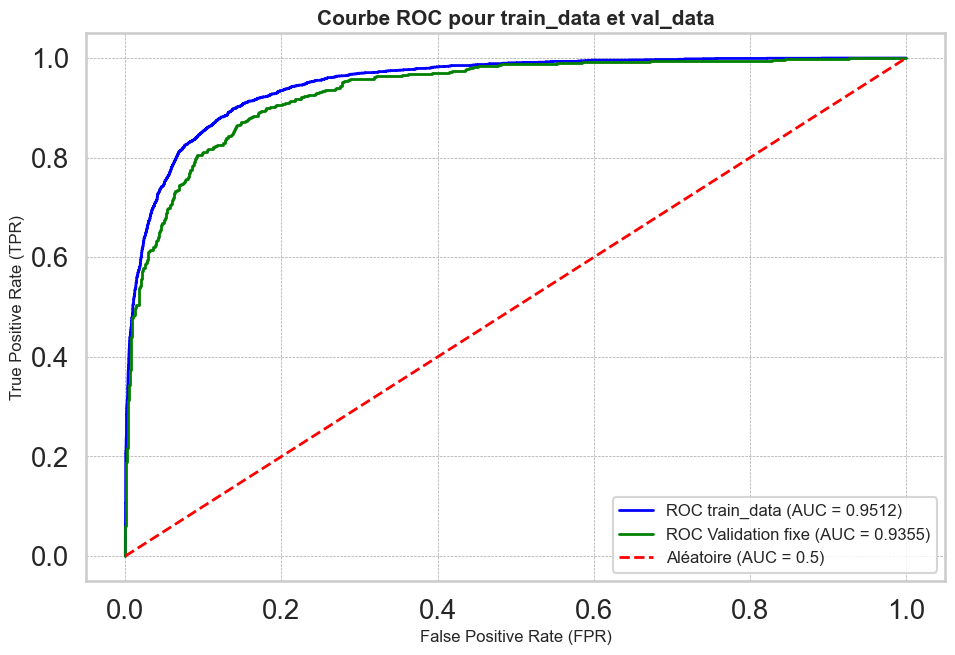

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calcul des courbes ROC pour TrainData
fpr_train, tpr_train, _ = roc_curve(train_data['Exited'], y_train_pred_catboost)
roc_auc_train = auc(fpr_train, tpr_train)

# Calcul des courbes ROC pour ValData
fpr_val, tpr_val, _ = roc_curve(y_val_fixe, y_val_fixe_pred)
roc_auc_val = auc(fpr_val, tpr_val)

plt.figure(figsize=(10, 7))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'ROC train_data (AUC = {roc_auc_train:.4f})')
plt.plot(fpr_val, tpr_val, color='green', lw=2, label=f'ROC Validation fixe (AUC = {roc_auc_val:.4f})')

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Aléatoire (AUC = 0.5)')

plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('Courbe ROC pour train_data et val_data', fontsize=15, fontweight='bold')
plt.legend(loc='lower right', fontsize=12)

plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()

plt.show()

In [28]:
# Colonnes de l'ensemble d'entraînement
print("Colonnes de l'ensemble d'entraînement (train) :")
print(train.columns)

# Colonnes de l'ensemble de test
print("\nColonnes de l'ensemble de test (test) :")
print(test.columns)

# L'on vérifie si des colonnes sont présentes dans train mais absentes dans test (et inversement)
train_columns = set(train.columns)
test_columns = set(test.columns)

print("\nColonnes présentes dans train mais absentes dans test :")
print(train_columns - test_columns)

print("\nColonnes présentes dans test mais absentes dans train :")
print(test_columns - train_columns)

Colonnes de l'ensemble d'entraînement (train) :
Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'NoBalance',
       'Geography_Germany', 'Geography_Spain', 'Gender_Male', 'Age_bin_31-40',
       'Age_bin_41-50', 'Age_bin_51-60', 'Age_bin_61+'],
      dtype='object')

Colonnes de l'ensemble de test (test) :
Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'NoBalance', 'Geography_Germany', 'Geography_Spain',
       'Gender_Male', 'Age_bin_31-40', 'Age_bin_41-50', 'Age_bin_51-60',
       'Age_bin_61+'],
      dtype='object')

Colonnes présentes dans train mais absentes dans test :
{'Exited'}

Colonnes présentes dans test mais absentes dans train :
{'id', 'CustomerId', 'Surname'}


In [29]:
# Suppression des variables présentes dans test mais absentes dans train
X_test = test.drop(columns=["id", "CustomerId", "Surname"], errors="ignore")

# Prédictions sur le jeu de test
test["prediction"] = final_model_cb.predict_proba(X_test)[:, 1]

# Création du fichier pour la soumission
submission = pd.DataFrame({
    "id": test["id"],
    "Exited": test["prediction"]
})

# Définition du chemin pour enregistrer le fichier de soumission
submission_path = os.path.join(os.getcwd(), "submission")
os.makedirs(submission_path, exist_ok=True)
submission_file = os.path.join(submission_path, "catboost_val_fixe.csv")

# Sauvegarde du fichier de soumission
submission.to_csv(submission_file, index=False)
print(f"Fichier de soumission généré avec succès : {submission_file}")

Fichier de soumission généré avec succès : c:\Users\kadas\Desktop\challenge_Data_mining\submission\catboost_val_fixe.csv
